# Analysis of hand drawn maps

This script is for analysing hand drawn maps of the Willunga sub-basin based on manual water table mapping exercise and survey and to make the figures for the paper.

Rasters are made in ArcGis using the hand drawn contour data and converting it to a raster using "Topo2Raster" tool

Script is run in the `conda activate geo_env` enviroment

## Import packages

In [1]:
from __future__ import division

#import affine
#import contextily
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import fiona
import geopandas as gpd
import math

import matplotlib as mpl
from   matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from   matplotlib.patches import Patch
from   matplotlib.ticker import FormatStrFormatter
import os
import numpy as np
import pyproj
import pandas as pd

import rasterio 
from   rasterio.crs import CRS
from   rasterio.enums import Resampling
from   rasterio.features import rasterize
import rasterio.mask
from   rasterio.plot import show
from   rasterio.transform import from_bounds
from   rasterio import shutil as rio_shutil
from   rasterio.vrt import WarpedVRT
from   rasterio import Affine

from   requests import Request
from   scipy.interpolate import interpn
from   scipy.interpolate import griddata
from   scipy import stats
import sys
import shapely
from   shapely.geometry import Point
from   shapely.geometry import mapping, Polygon
import string
from   owslib.wcs import WebCoverageService



%matplotlib inline

In [2]:
wt_cmap = 'rainbow'

In [3]:
filelocation = r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\results_arrays'
figure_directory = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper'

In [6]:
names_list = []
arrays_list = []

for file in os.listdir(filelocation):
    if file.endswith(".out"):
        names_list.append(file)
        ar = np.loadtxt(os.path.join(filelocation, file))
        arrays_list.append(ar)
    else:
        pass
    
print(names_list)
print(len(names_list))

['001.out', '002.out', '003.out', '004.out', '005.out', '008.out', '009.out', '012.out', '012b.out', '014.out', '016.out', '017.out', '021.out', '024.out', '025.out', '026.out', '028.out', '029.out', '030.out', '031.out', '032.out', '033.out', '034.out', '036.out', '037.out', '043.out', '044.out', '045.out', '047.out', '048.out', '049.out', '050.out', 'AAA3.out', 'AGC_001.out', 'AGC_011.out', 'AGC_014.out', 'AGC_015.out', 'AGC_016.out', 'AGC_018.out', 'BARD.out', 'BB01.out', 'C01.out', 'DEW_01.out', 'DEW_02.out', 'DEW_03.out', 'DEW_04.out', 'EMM01.out', 'E_0123.out', 'GH01.out', 'J5897.out', 'JAR.out', 'LW.out', 'NB.out', 'R01.out', 'R051.out', 'RS01.out', 'SJ01.out', 'TV_001.out', 'UWA_001.out', 'UWA_002.out', 'UWA_003.out', 'U_1949.out', 'XZ01.out']
63


In [7]:
survey_levels = [0,10,20,30,40,50,60,70,80,90,100,125,150,175,200,225]

### Plotting all maps

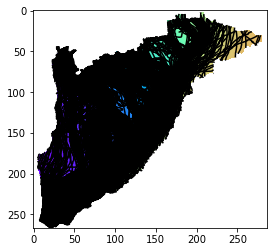

In [8]:
plt.figure()
for i in range(len(arrays_list)):
    #plt.figure()
    plt.imshow(arrays_list[i], cmap=wt_cmap, vmin=-10, vmax=350, alpha=0.1)
    cs = plt.contour(arrays_list[i], levels=survey_levels, colors="k") 

### Calulate statistics

In [9]:
wt_array_stack = np.dstack(arrays_list)
print(wt_array_stack.shape)
wt_array_stack = np.moveaxis(wt_array_stack, source=2, destination=0)
print(wt_array_stack.shape)

(267, 287, 63)
(63, 267, 287)


In [10]:
max_array = np.amax(wt_array_stack, axis=0)
min_array = np.amin(wt_array_stack, axis=0)
range_array = max_array - min_array
std_array = np.nanstd(wt_array_stack, axis=0)
mean_array = np.nanmean(wt_array_stack, axis=0)

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\mar886\AppData\Local\Temp/ipykernel_14584/1839270943.py:5: RuntimeWarning: Mean of empty slice
  mean_array = np.nanmean(wt_array_stack, axis=0)


### Plot statistics

In [11]:
mean_array

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

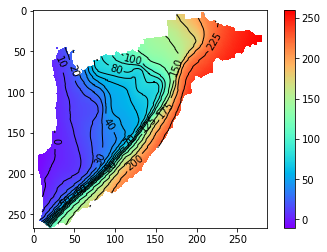

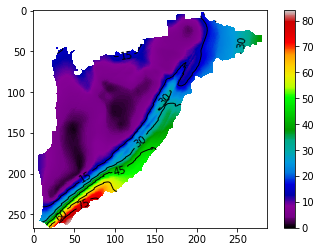

In [12]:
plt.figure()
m = plt.imshow(mean_array, cmap=wt_cmap)
cs = plt.contour(mean_array, levels=survey_levels, colors="k", linewidths=1)
plt.clabel(cs)
plt.colorbar(m)

plt.figure()
s = plt.imshow(std_array, cmap='nipy_spectral')
cs = plt.contour(std_array, colors="k", linewidths=1)
plt.clabel(cs)
plt.colorbar(s)

### Coefficient of variation

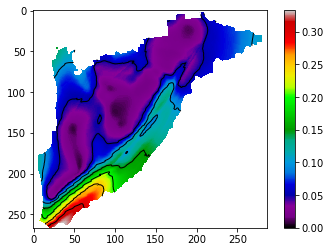

In [13]:
coeff_of_var = std_array/np.abs(mean_array+100)

# It needs to be scaled, if the values are too close to 0 they are just ridiculous...

plt.figure()
c = plt.imshow(coeff_of_var, cmap='nipy_spectral')
plt.contour(coeff_of_var, colors="k", linewidths=1)
plt.colorbar(c)

### Highlight variability on plain

- Doens't show much extra

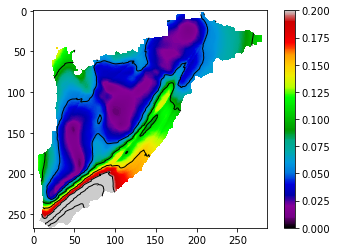

In [14]:
plt.figure()
c = plt.imshow(coeff_of_var, cmap='nipy_spectral', vmax=0.2)
plt.contour(coeff_of_var, colors="k", linewidths=1)
plt.colorbar(c)

### Highlight variability on the hills

- Doesn't really show much extra either

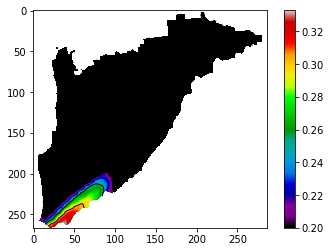

In [15]:
plt.figure()
c = plt.imshow(coeff_of_var, cmap='nipy_spectral', vmin=0.2)
plt.contour(coeff_of_var, colors="k", linewidths=1)
plt.colorbar(c)

### Plot variation in a few key parts

BUT I SHOULD DO THIS WITH THE ACTUAL SHAPE FILES NOT THE CONTOURS FROM THE RASTER - THEY ARE DIFFERENT

C:\Users\mar886\AppData\Local\Temp/ipykernel_14584/2619860221.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


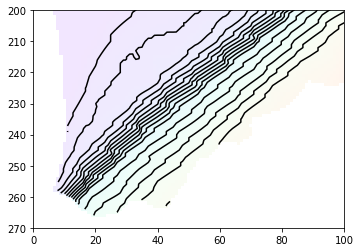

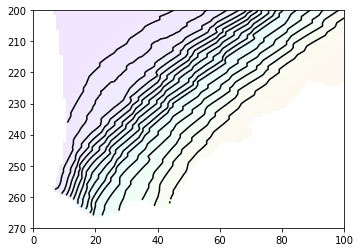

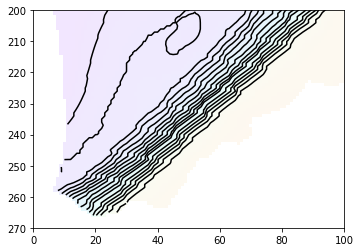

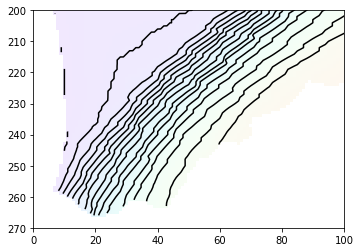

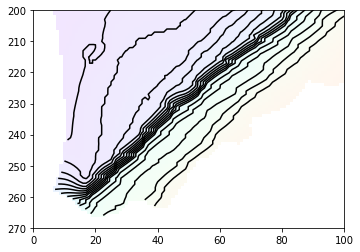

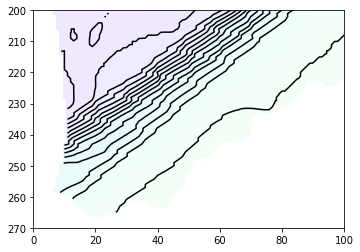

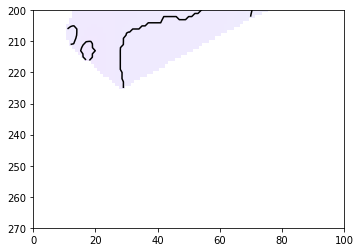

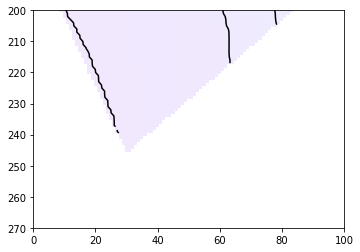

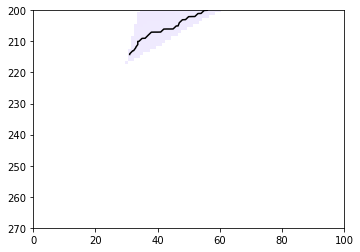

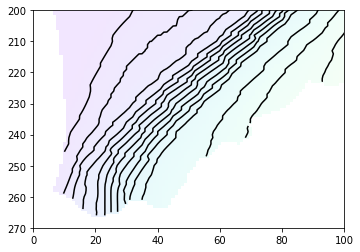

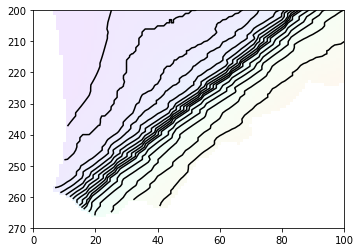

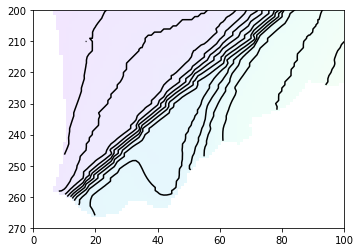

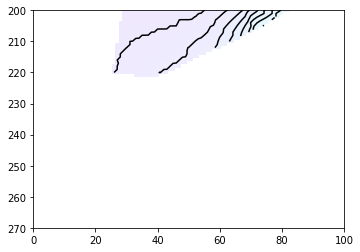

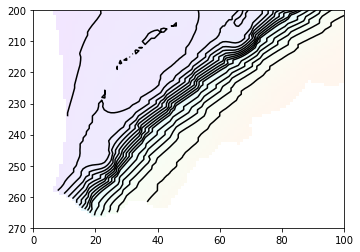

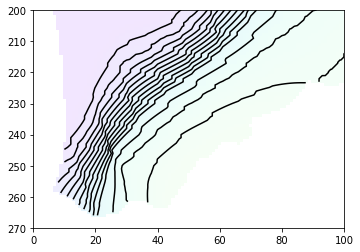

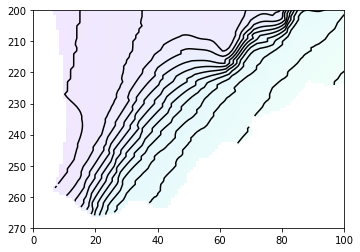

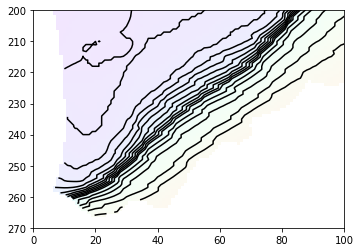

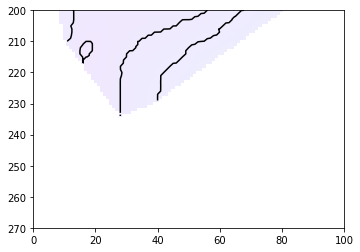

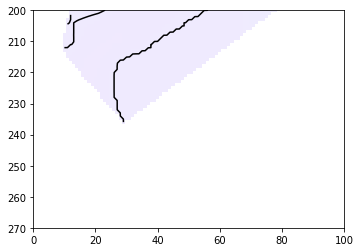

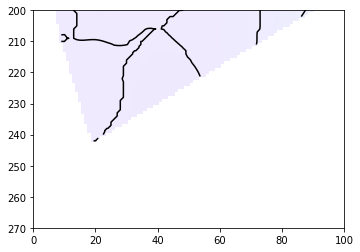

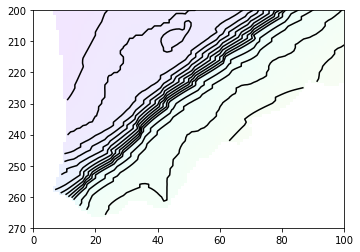

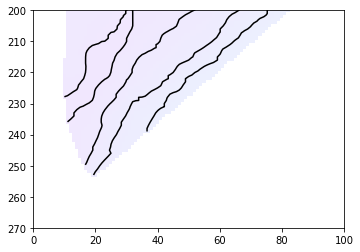

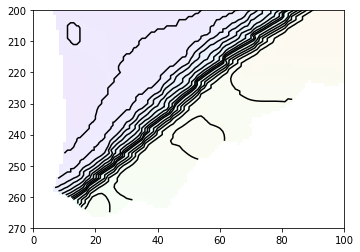

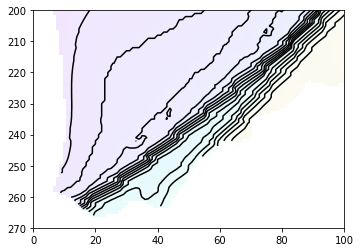

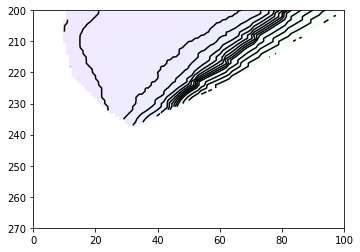

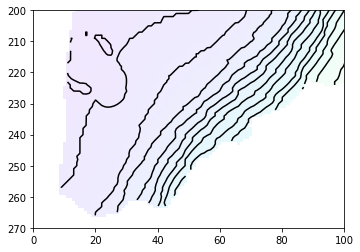

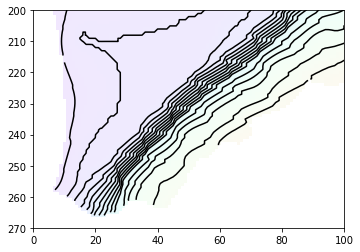

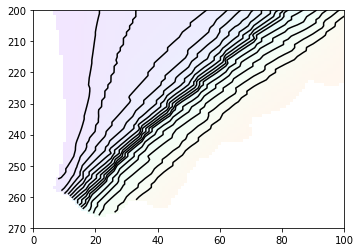

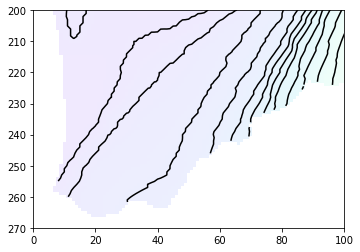

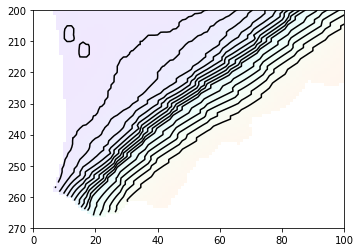

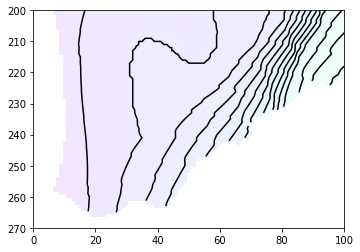

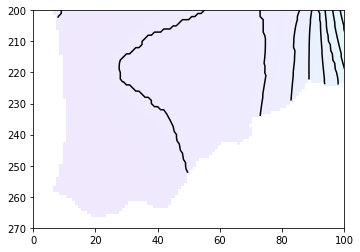

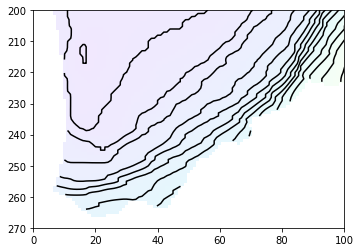

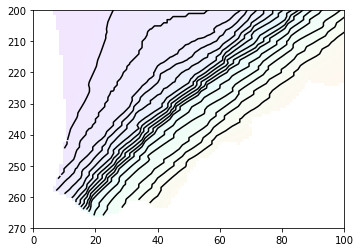

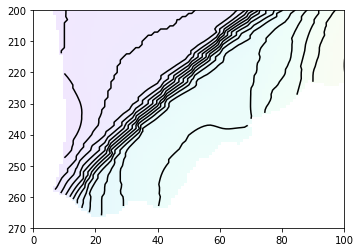

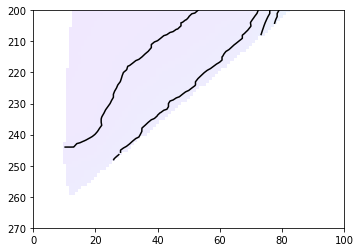

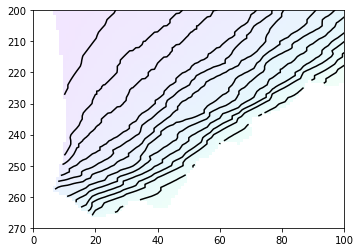

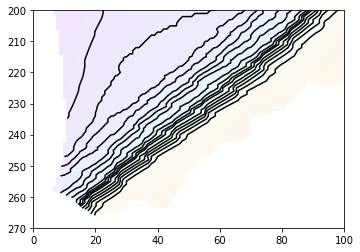

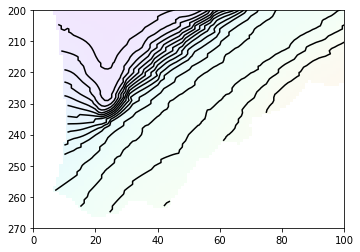

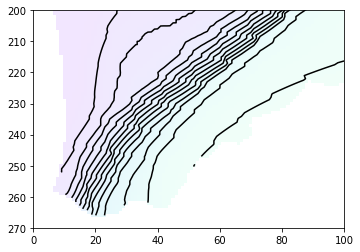

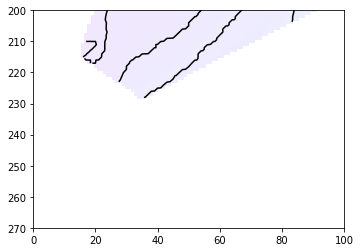

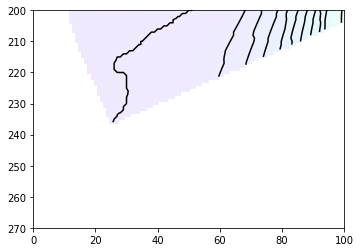

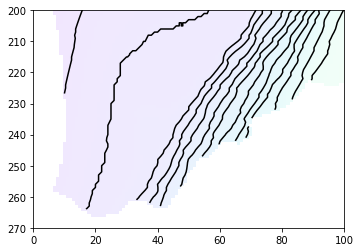

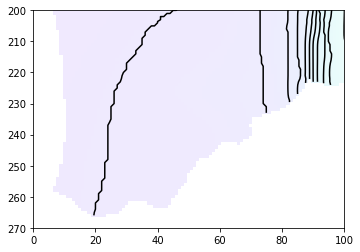

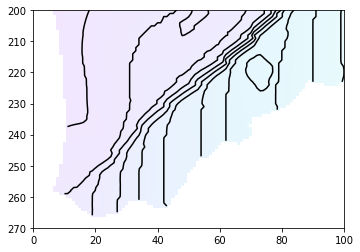

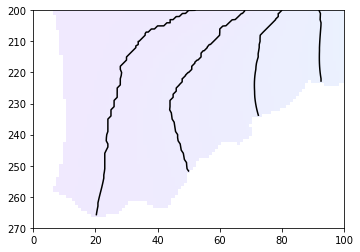

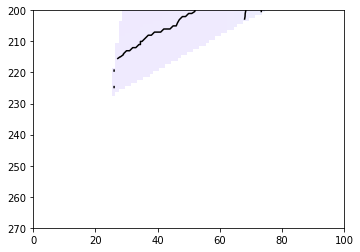

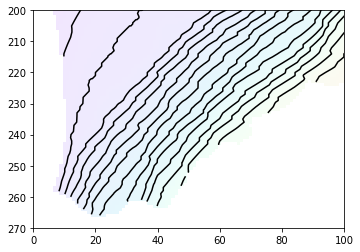

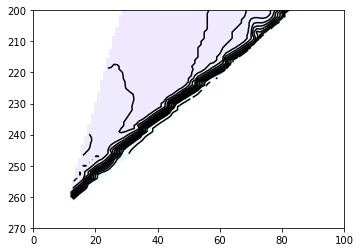

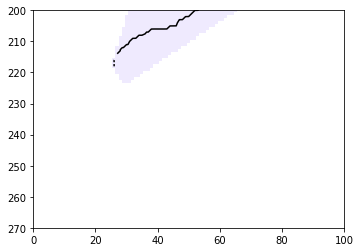

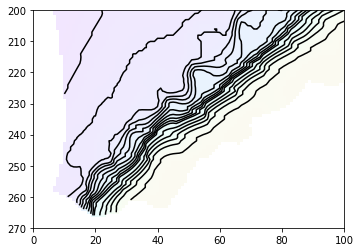

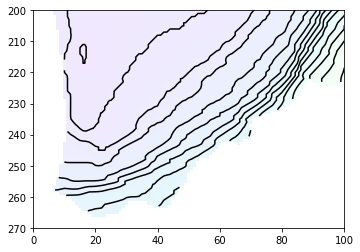

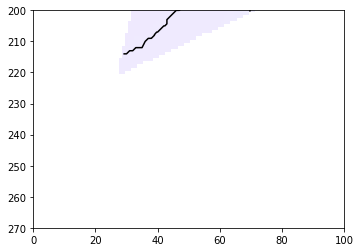

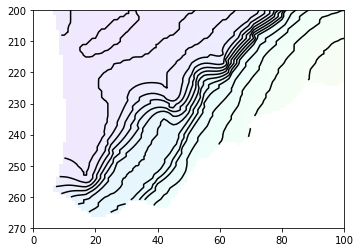

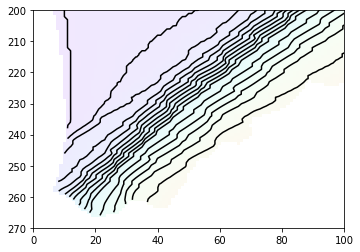

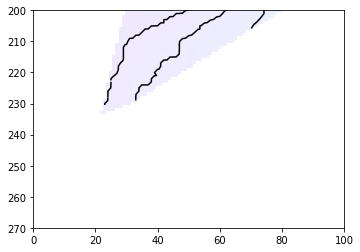

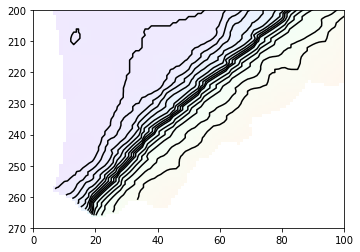

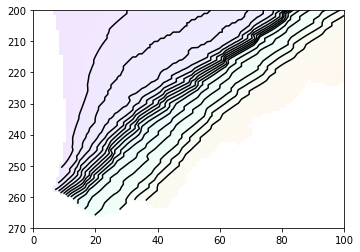

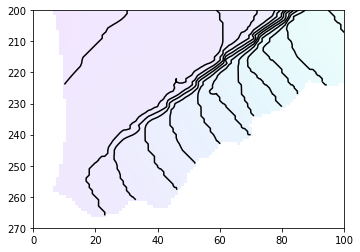

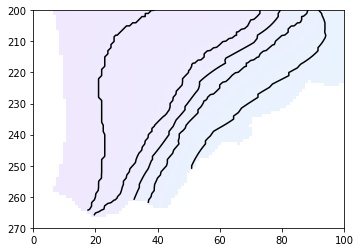

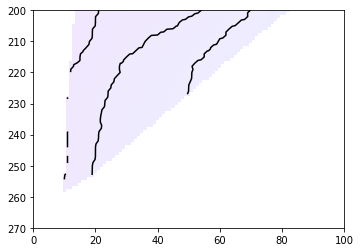

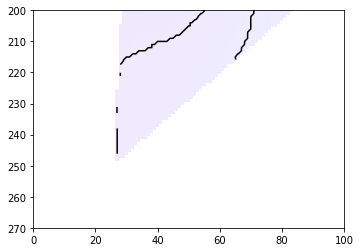

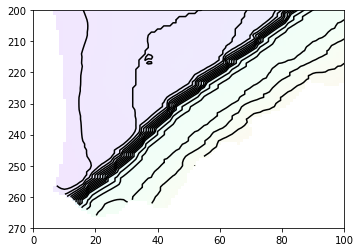

In [16]:
#plt.figure()
for i in range(len(arrays_list)):
    plt.figure()
    plt.imshow(arrays_list[i], cmap=wt_cmap, vmin=-10, vmax=350, alpha=0.1)
    #plt.ylim(200,250)
    cs = plt.contour(arrays_list[i], levels=survey_levels, colors="k") 
    
    plt.xlim(0,100)
    plt.ylim(200,270)
    axes = plt.gca()
    axes.invert_yaxis()

C:\Users\mar886\AppData\Local\Temp/ipykernel_14584/1026238948.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


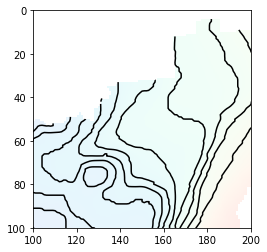

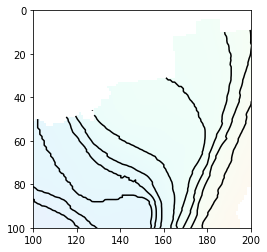

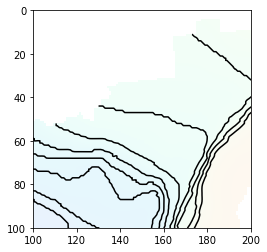

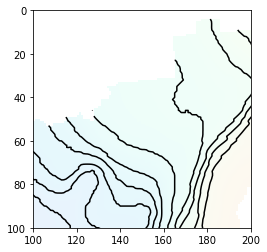

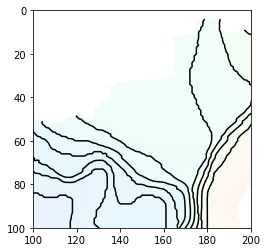

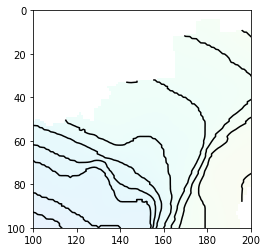

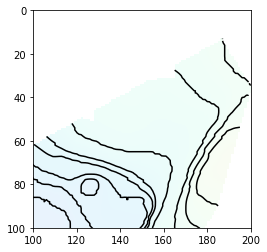

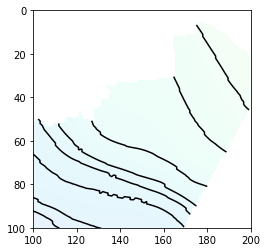

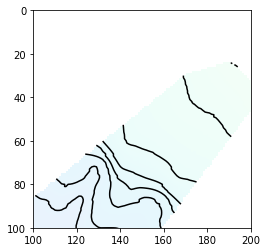

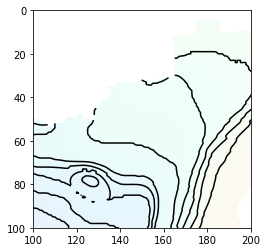

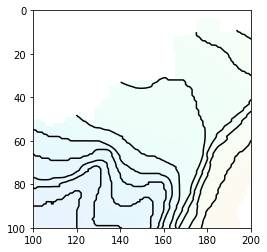

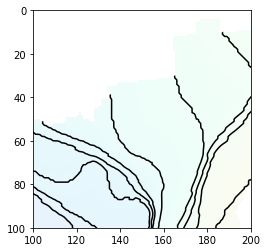

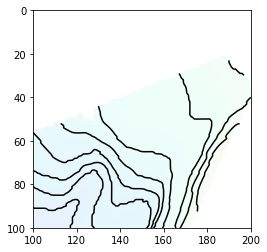

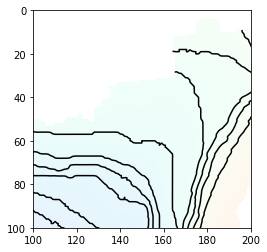

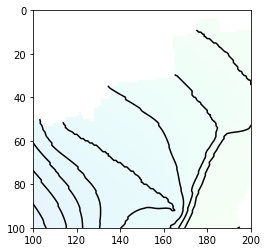

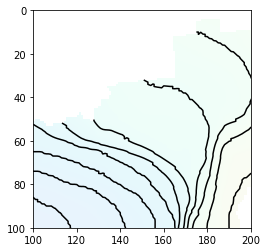

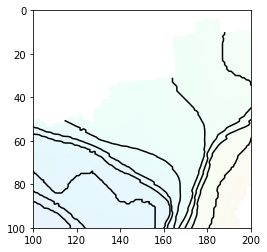

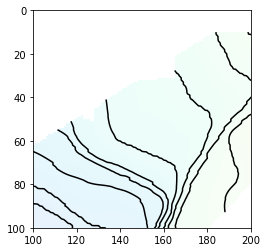

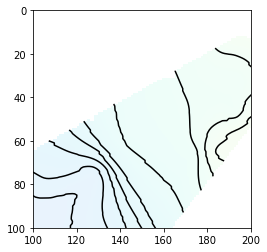

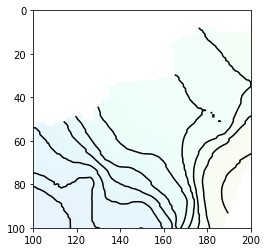

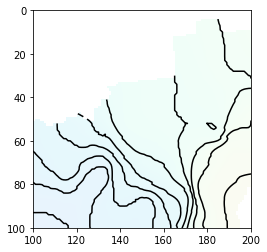

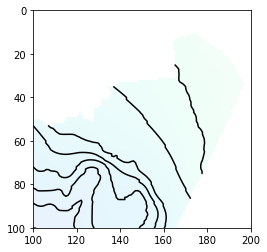

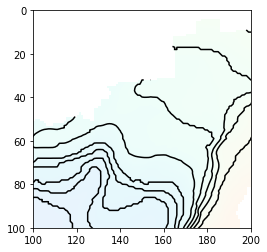

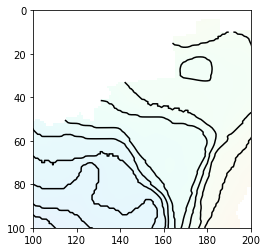

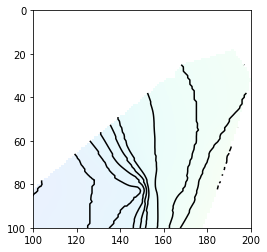

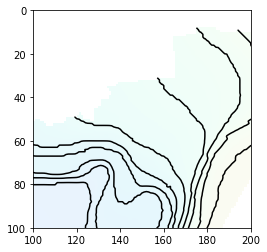

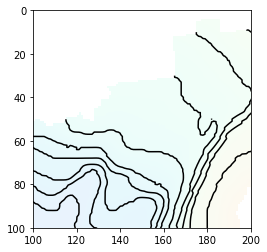

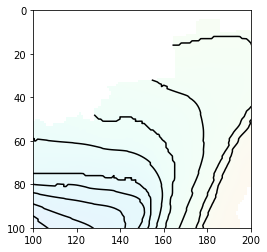

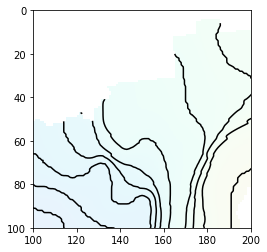

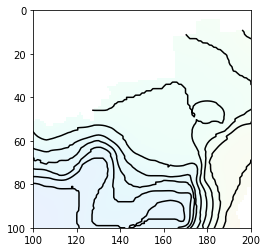

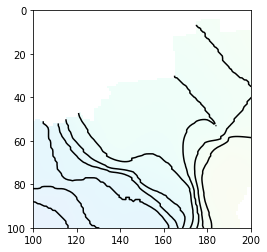

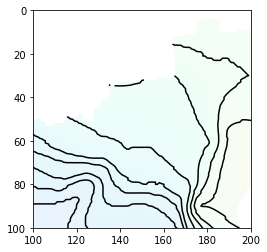

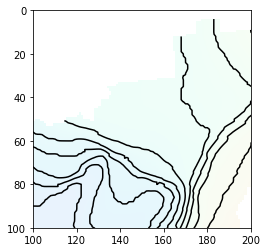

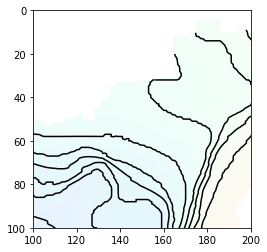

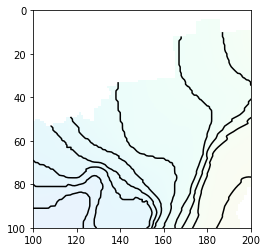

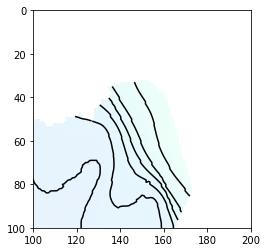

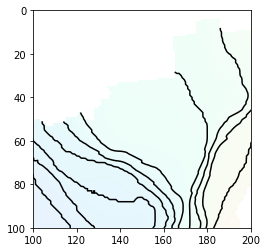

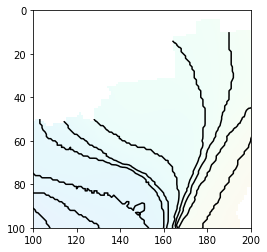

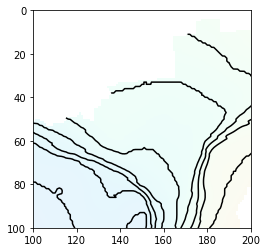

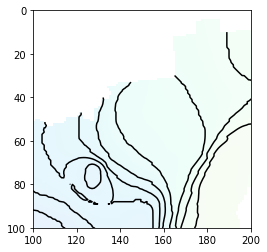

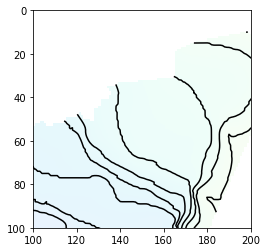

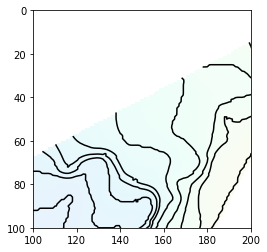

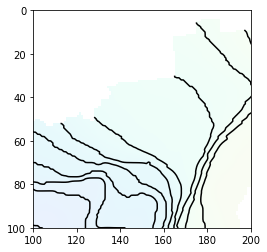

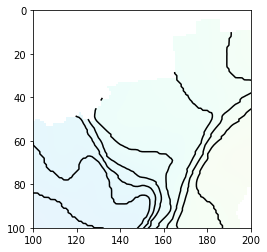

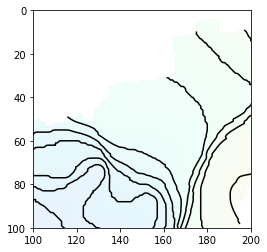

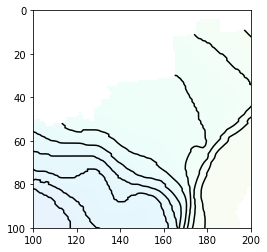

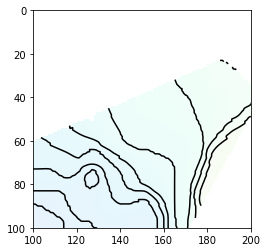

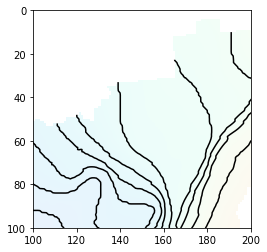

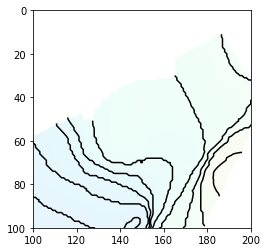

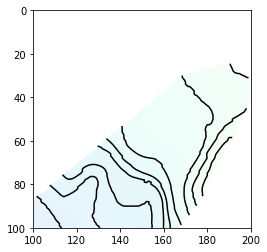

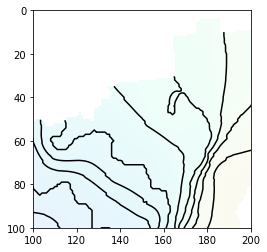

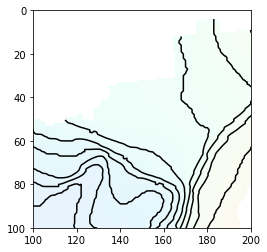

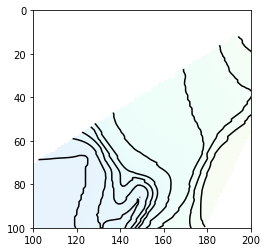

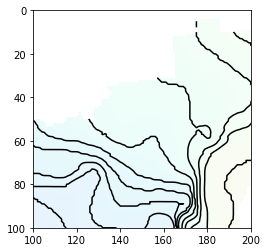

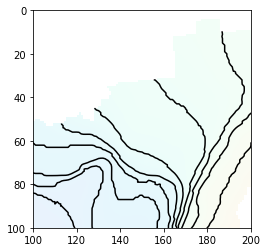

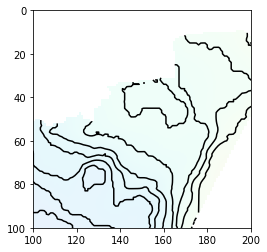

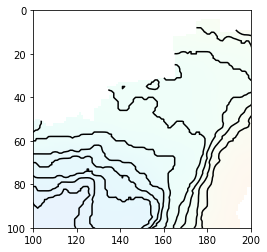

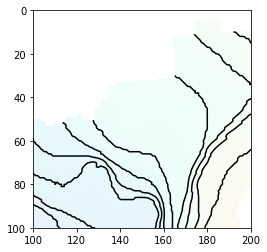

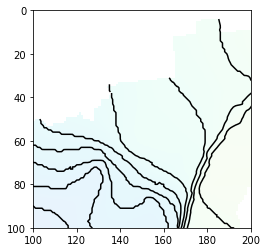

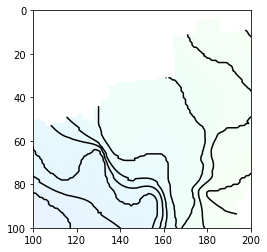

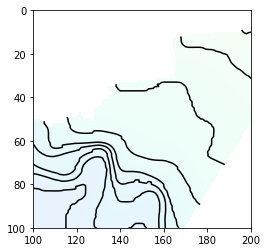

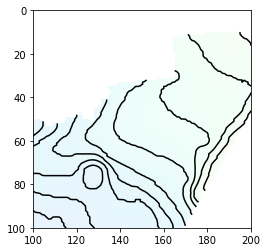

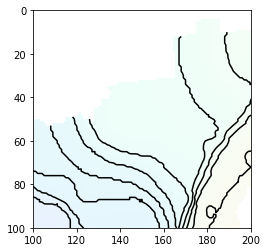

In [17]:
#plt.figure()
for i in range(len(arrays_list)):
    plt.figure()
    plt.imshow(arrays_list[i], cmap=wt_cmap, vmin=-10, vmax=350, alpha=0.1)
    #plt.ylim(200,250)
    cs = plt.contour(arrays_list[i], levels=survey_levels, colors="k") 
    
    plt.xlim(100,200)
    plt.ylim(0,100)
    axes = plt.gca()
    axes.invert_yaxis()

## Pull in well indices

In [18]:

f_well_ixs = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data',
                         "df_well_ixs.csv")

df_well_ixs = pd.read_csv(f_well_ixs)

df_well_ixs = df_well_ixs.drop(columns=['DHNO.1'])
df_well_ixs.head()

DHNO   rswl    well_ix  well_ix_x  well_ix_y letter
0  26558   4.09  (186, 20)        186         20    NaN
1  26565   4.33  (155, 40)        155         40    NaN
2  26585  18.22  (144, 56)        144         56    NaN
3  27050   5.54  (195, 50)        195         50    NaN
4  27063  15.90  (217, 35)        217         35    NaN

## Plots for paper

In [19]:
letters = ['a','b','c','d','e','f','g','h','i']

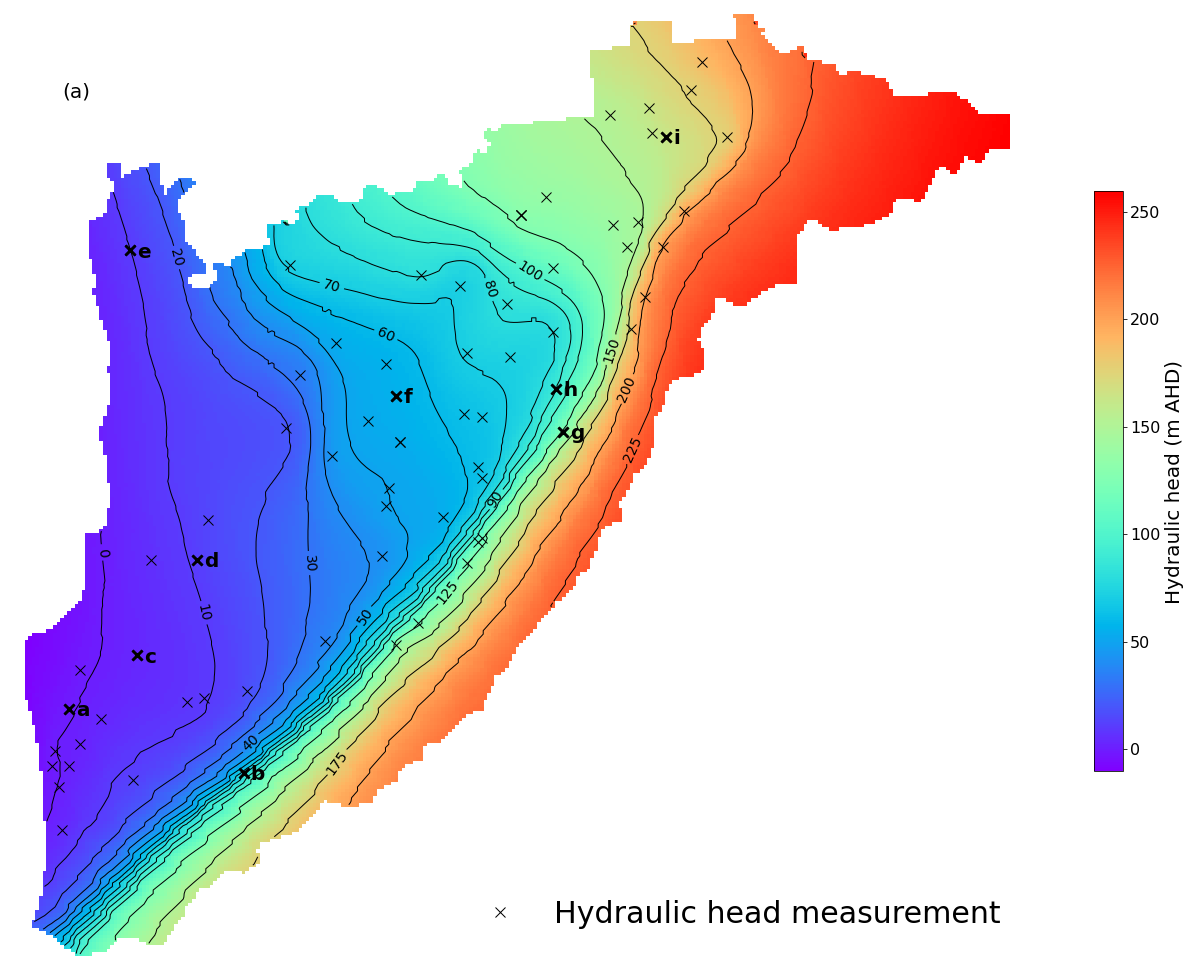

In [20]:
plt.figure(figsize=(20,20))

axes=plt.subplot(111, frameon=False)

m = plt.imshow(mean_array, cmap=wt_cmap)
cs = plt.contour(mean_array, levels=survey_levels, colors="k", linewidths=1)
plt.clabel(cs, inline=1, fontsize=14, fmt='%1i', colors="k")
cb = plt.colorbar(m, fraction=0.026, pad=0.06)

axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

for t in cb.ax.get_yticklabels():
     t.set_fontsize(16)
        
cb.set_label("Hydraulic head (m AHD)", fontsize=20)

for i in range(len(df_well_ixs)):
    y = df_well_ixs.iloc[i,3]
    x = df_well_ixs.iloc[i,4]
    letter = df_well_ixs.iloc[i,5]
    plt.plot(x,y,'x',c='k', markersize=10, label='_nolegend_')
    if letter in letters:
        plt.text(x+2,y+2,letter, fontsize=20, fontweight='bold',c="k")
        plt.plot(x,y,'x',c='k', markersize=10, markeredgewidth=3, label='_nolegend_')
    
axes.plot(x,y, "kx", alpha=1, markersize=10, label="Hydraulic head measurement")    
plt.legend(frameon=False, fontsize=30, loc=4)

plt.text(15,25, "(a)", fontsize=20)

nm = os.path.join(figure_directory, "mean")
plt.savefig(nm, dpi=300)

In [26]:
levels_std=np.arange(0,90,5)
print(levels_std)

[ 0  5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85]


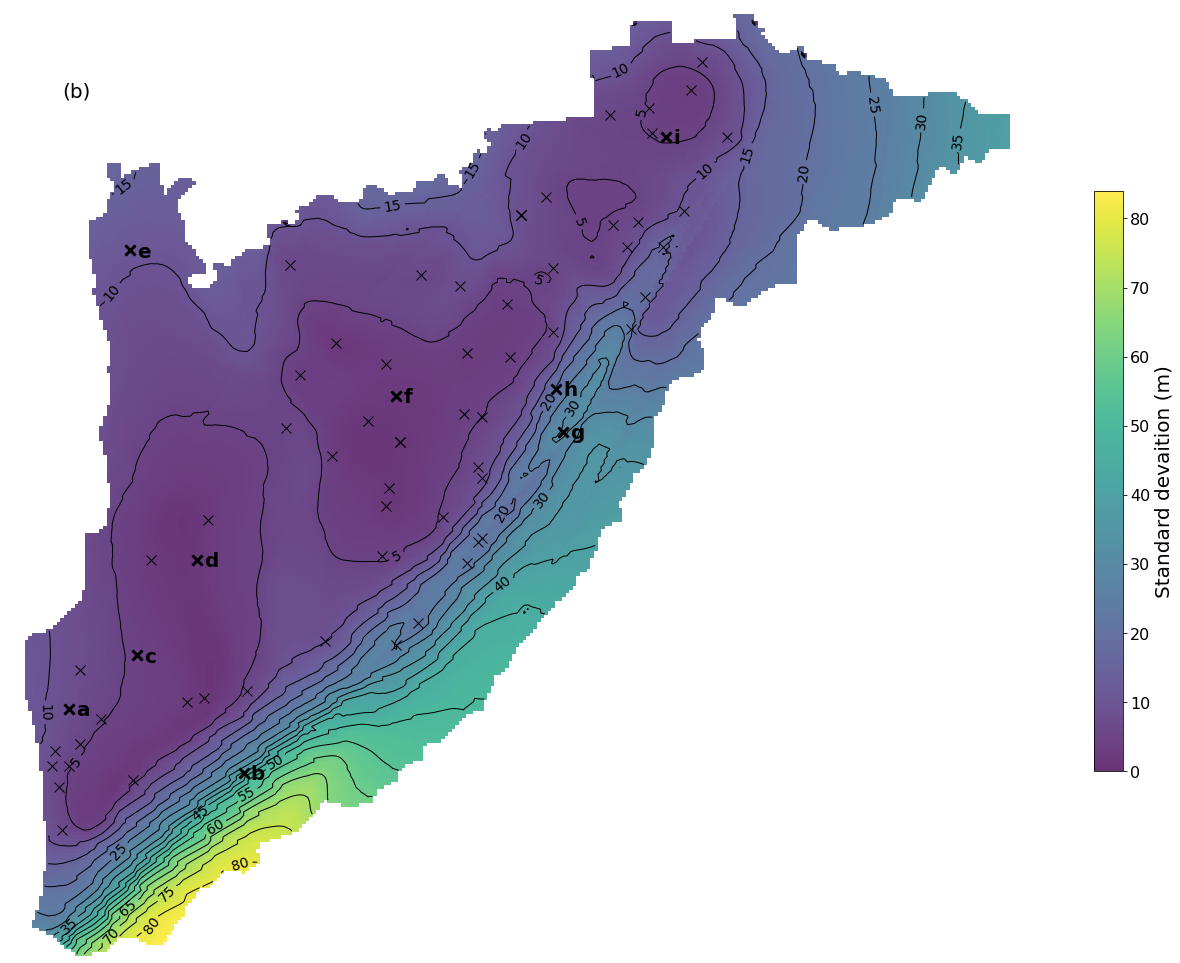

In [27]:
plt.figure(figsize=(20,20))

axes=plt.subplot(111, frameon=False)

m = plt.imshow(std_array, cmap='viridis', alpha=0.8)
cs = plt.contour(std_array, levels=levels_std, colors="k", linewidths=1)
plt.clabel(cs, inline=1, fontsize=14, fmt='%1i', colors="k")
cb = plt.colorbar(m, fraction=0.026, pad=0.06)

axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

for t in cb.ax.get_yticklabels():
     t.set_fontsize(16)
        
cb.set_label("Standard devaition (m)", fontsize=20)

for i in range(len(df_well_ixs)):
    y = df_well_ixs.iloc[i,3]
    x = df_well_ixs.iloc[i,4]
    letter = df_well_ixs.iloc[i,5]
    plt.plot(x,y,'x',c='k', markersize=10, label='_nolegend_')
    if letter in letters:
        plt.text(x+2,y+2,letter, fontsize=20, fontweight='bold',c="k")
        plt.plot(x,y,'x',c='k', markersize=10, markeredgewidth=3,label='_nolegend_')
    
#axes.plot(x,y, "kx", alpha=1, markersize=10, label="Hydraulic head measurement")    
#plt.legend(frameon=False, fontsize=18, loc=4)

plt.text(15,25, "(b)", fontsize=20)

nm = os.path.join(figure_directory, "std")
plt.savefig(nm, dpi=300)

# Pull in shapefiles

In [28]:
wt_contour_shp_fldr = r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data\wt_drawn_contours'

nm = 'ref_001_contours.shp'
contours_shp = gpd.read_file(os.path.join(wt_contour_shp_fldr,nm))

In [29]:
names_list[0][:-4]

'001'

In [32]:
contour_shp_name_list = []
contour_shps_list = []

for i in range(len(names_list)):
    nm = "ref_%s_contours.shp"%names_list[i][:-4]
    contour_shp_name_list.append(nm)
    contours_shp = gpd.read_file(os.path.join(wt_contour_shp_fldr,nm))
    contour_shps_list.append(contours_shp)

print(len(names_list))

print(len(contour_shps_list))

63
63


In [58]:
#Rename ref_030_contours.shp --> issue with contour column name
contour_shps_list[18]=contour_shps_list[18].rename(columns={"Contours_m":"Contour_m"})

#Rename ref_045_contours.shp --> issue with contour column name

contour_shps_list[27]=contour_shps_list[27].rename(columns={"Contours_m":"Contour_m"})

#contour_shps_list[17]

In [102]:
#Rename ref_047_contours.shp --> issue with contour column name

contour_shps_list[28]=contour_shps_list[28].rename(columns={"contour_m":"Contour_m"})

#Rename ref_048_contours.shp --> issue with contour column name

contour_shps_list[29]=contour_shps_list[29].rename(columns={"contour_m":"Contour_m"})

#Rename ref_050_contours.shp --> issue with contour column name

contour_shps_list[31]=contour_shps_list[31].rename(columns={"contours_m":"Contour_m"})

#Rename ref_AAA3_contours.shp --> issue with contour column name

contour_shps_list[32]=contour_shps_list[32].rename(columns={"Contours_m":"Contour_m"})

#Rename ref_AGC_011_contours.shp --> issue with contour column name

contour_shps_list[34]=contour_shps_list[34].rename(columns={"contour_m":"Contour_m"})

#Rename ref_BARD_contours.shp --> issue with contour column name

contour_shps_list[39]=contour_shps_list[39].rename(columns={"Contours_m":"Contour_m"})

#Rename ref_C01_contours.shp --> issue with contour column name

contour_shps_list[41]=contour_shps_list[41].rename(columns={"contour_m":"Contour_m"})

#Rename ref_GH01_contours.shp --> issue with contour column name

contour_shps_list[48]=contour_shps_list[48].rename(columns={"contours_m":"Contour_m"})

#Rename ref_RS01_contours.shp --> issue with contour column name

contour_shps_list[55]=contour_shps_list[55].rename(columns={"contours_m":"Contour_m"})

#Rename ref_SJ01_contours.shp --> issue with contour column name

contour_shps_list[56]=contour_shps_list[56].rename(columns={"Contours_m":"Contour_m"})

In [105]:
#Rename ref_UWA_003_contours.shp --> issue with contour column name

contour_shps_list[60]=contour_shps_list[60].rename(columns={"Contours_m":"Contour_m"})

## Pull in shapefile of study area

In [35]:
study_extent_path = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\hand_output_rasters\study_extent', 'study_extent.shp')
study_area_shp = gpd.read_file(study_extent_path)

## Plot individual contours, how simiar/different were they from one another

In [104]:
print(i)
print(contour_shp_name_list[i])
print(contour_shps_list[i].columns)


60
ref_UWA_003_contours.shp
Index(['Contours_m', 'geometry'], dtype='object')


In [107]:
vl=8

survey_levels_1 = survey_levels[1:-1]

for vl in range(len(survey_levels_1)):
    print("number: %i"%vl)

    plt.figure(figsize=(10,10))

    ax1=plt.subplot(111)
    study_area_shp.exterior.plot(ax=ax1, color="k", label="Study area")

    colour = cm.cool_r(np.linspace(0, 1, 40))
    contour_v = survey_levels_1[vl]


    for i in range(len(contour_shps_list)):
        #print(contour_shp_name_list[i])
        #print("i:%i"%i)
        c = 'k'#colour[i]
        contour_shps_list[i][contour_shps_list[i]["Contour_m"]==contour_v].plot(ax=ax1, color=c, label="Contours")

    nm = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\Individual_contour_comparison',
                     "contour_value_%i"%contour_v)

    plt.savefig(nm, dpi=300)
    plt.close()
    

number: 0


C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

number: 1


C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

number: 2


C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

number: 3


C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

number: 4


C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

number: 5


C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

number: 6


C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

number: 7


C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

number: 8


C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

number: 9


C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

number: 10


C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

number: 11


C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

number: 12


C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

number: 13


C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

## Plot the same thing but as an single figure

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

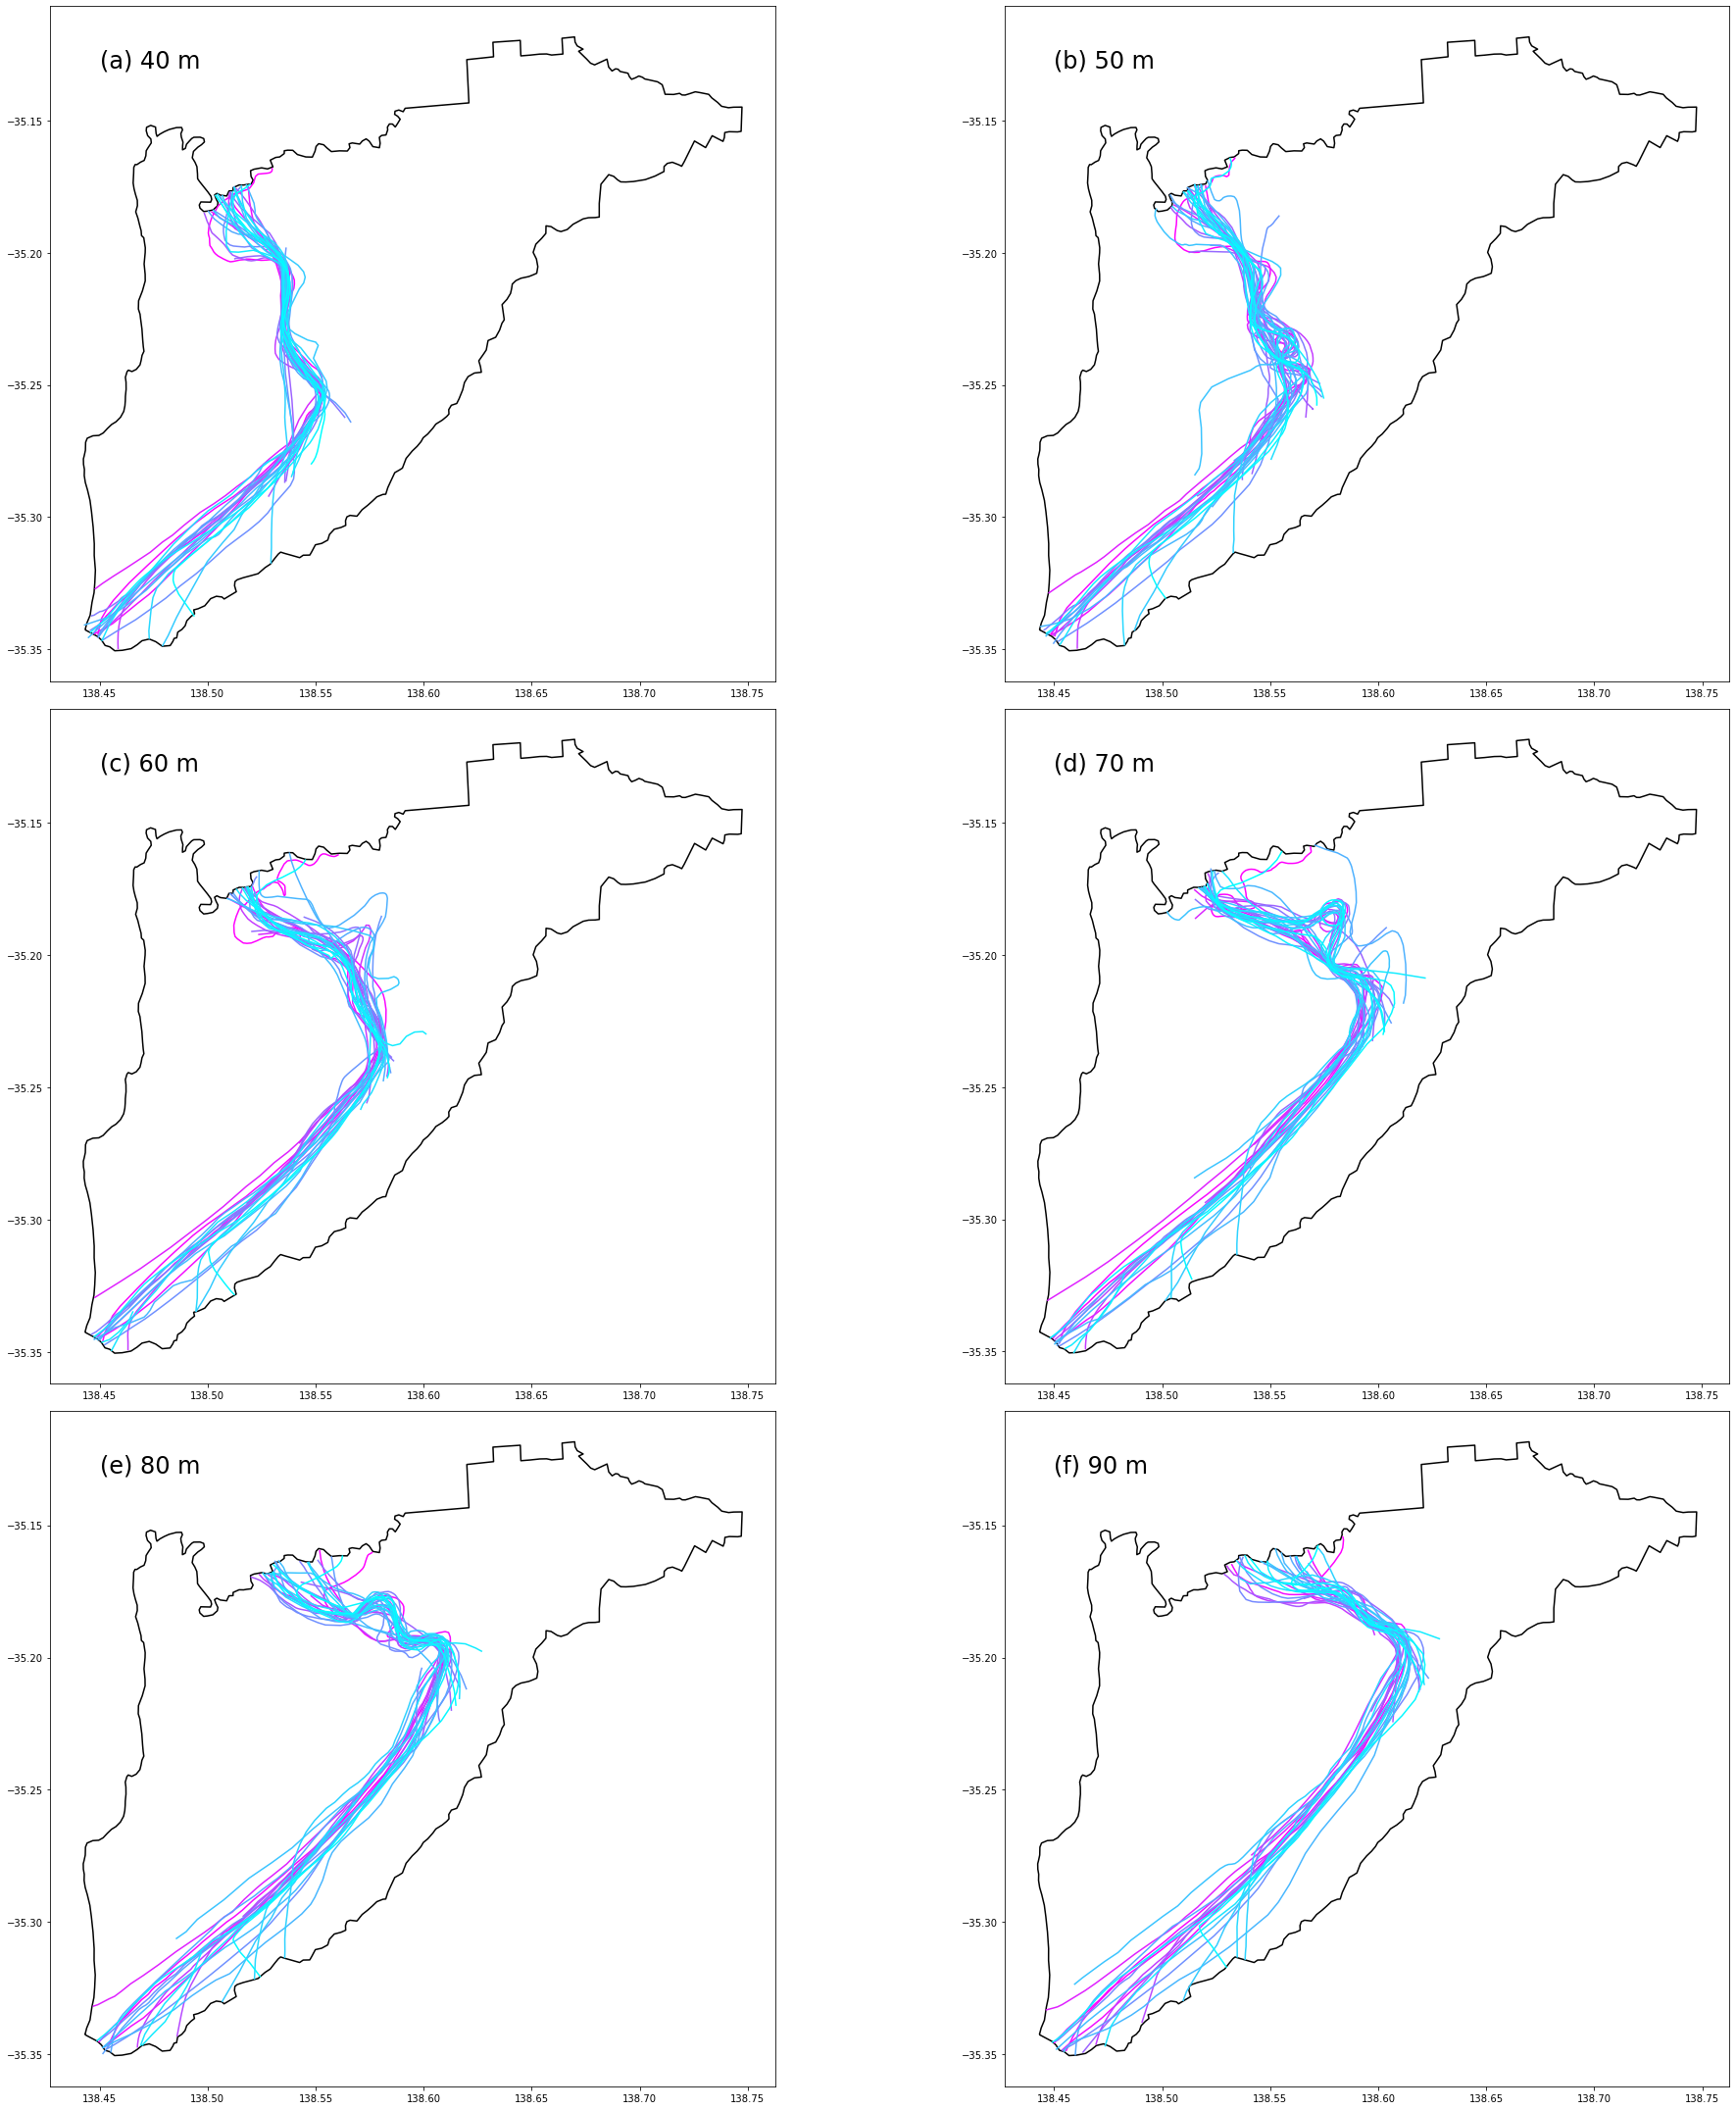

In [27]:
vl=8
survey_levels_1 = [40, 50, 60, 70, 80, 90]

captions = ["(a) 40 m", "(b) 50 m", "(c) 60 m", "(d) 70 m", "(e) 80 m", "(f) 90 m"]

fig = plt.figure(figsize=(30,30))

for vl in range(len(survey_levels_1)):

    ax1=fig.add_subplot(3,2,(vl+1))
    study_area_shp.exterior.plot(ax=ax1, color="k", label="Study area")

    colour = cm.cool_r(np.linspace(0, 1, 40))
    contour_v = survey_levels_1[vl]

    for i in range(len(contour_shps_list)):
        #print(contour_shp_name_list[i])
        #print("i:%i"%i)
        c = colour[i]
        contour_shps_list[i][contour_shps_list[i]["Contour_m"]==contour_v].plot(ax=ax1, color=c, label="Contours")
        
    plt.text(138.45,-35.13,captions[vl], fontsize=24)

plt.tight_layout()
nm = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\Individual_contour_comparison',
                     "some_contours")

plt.savefig(nm, dpi=300)

# Plot just the 80m contour

C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anaconda3\envs\geo_env\lib\site-packages\geopandas\plotting.py:681: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\mar886\Anac

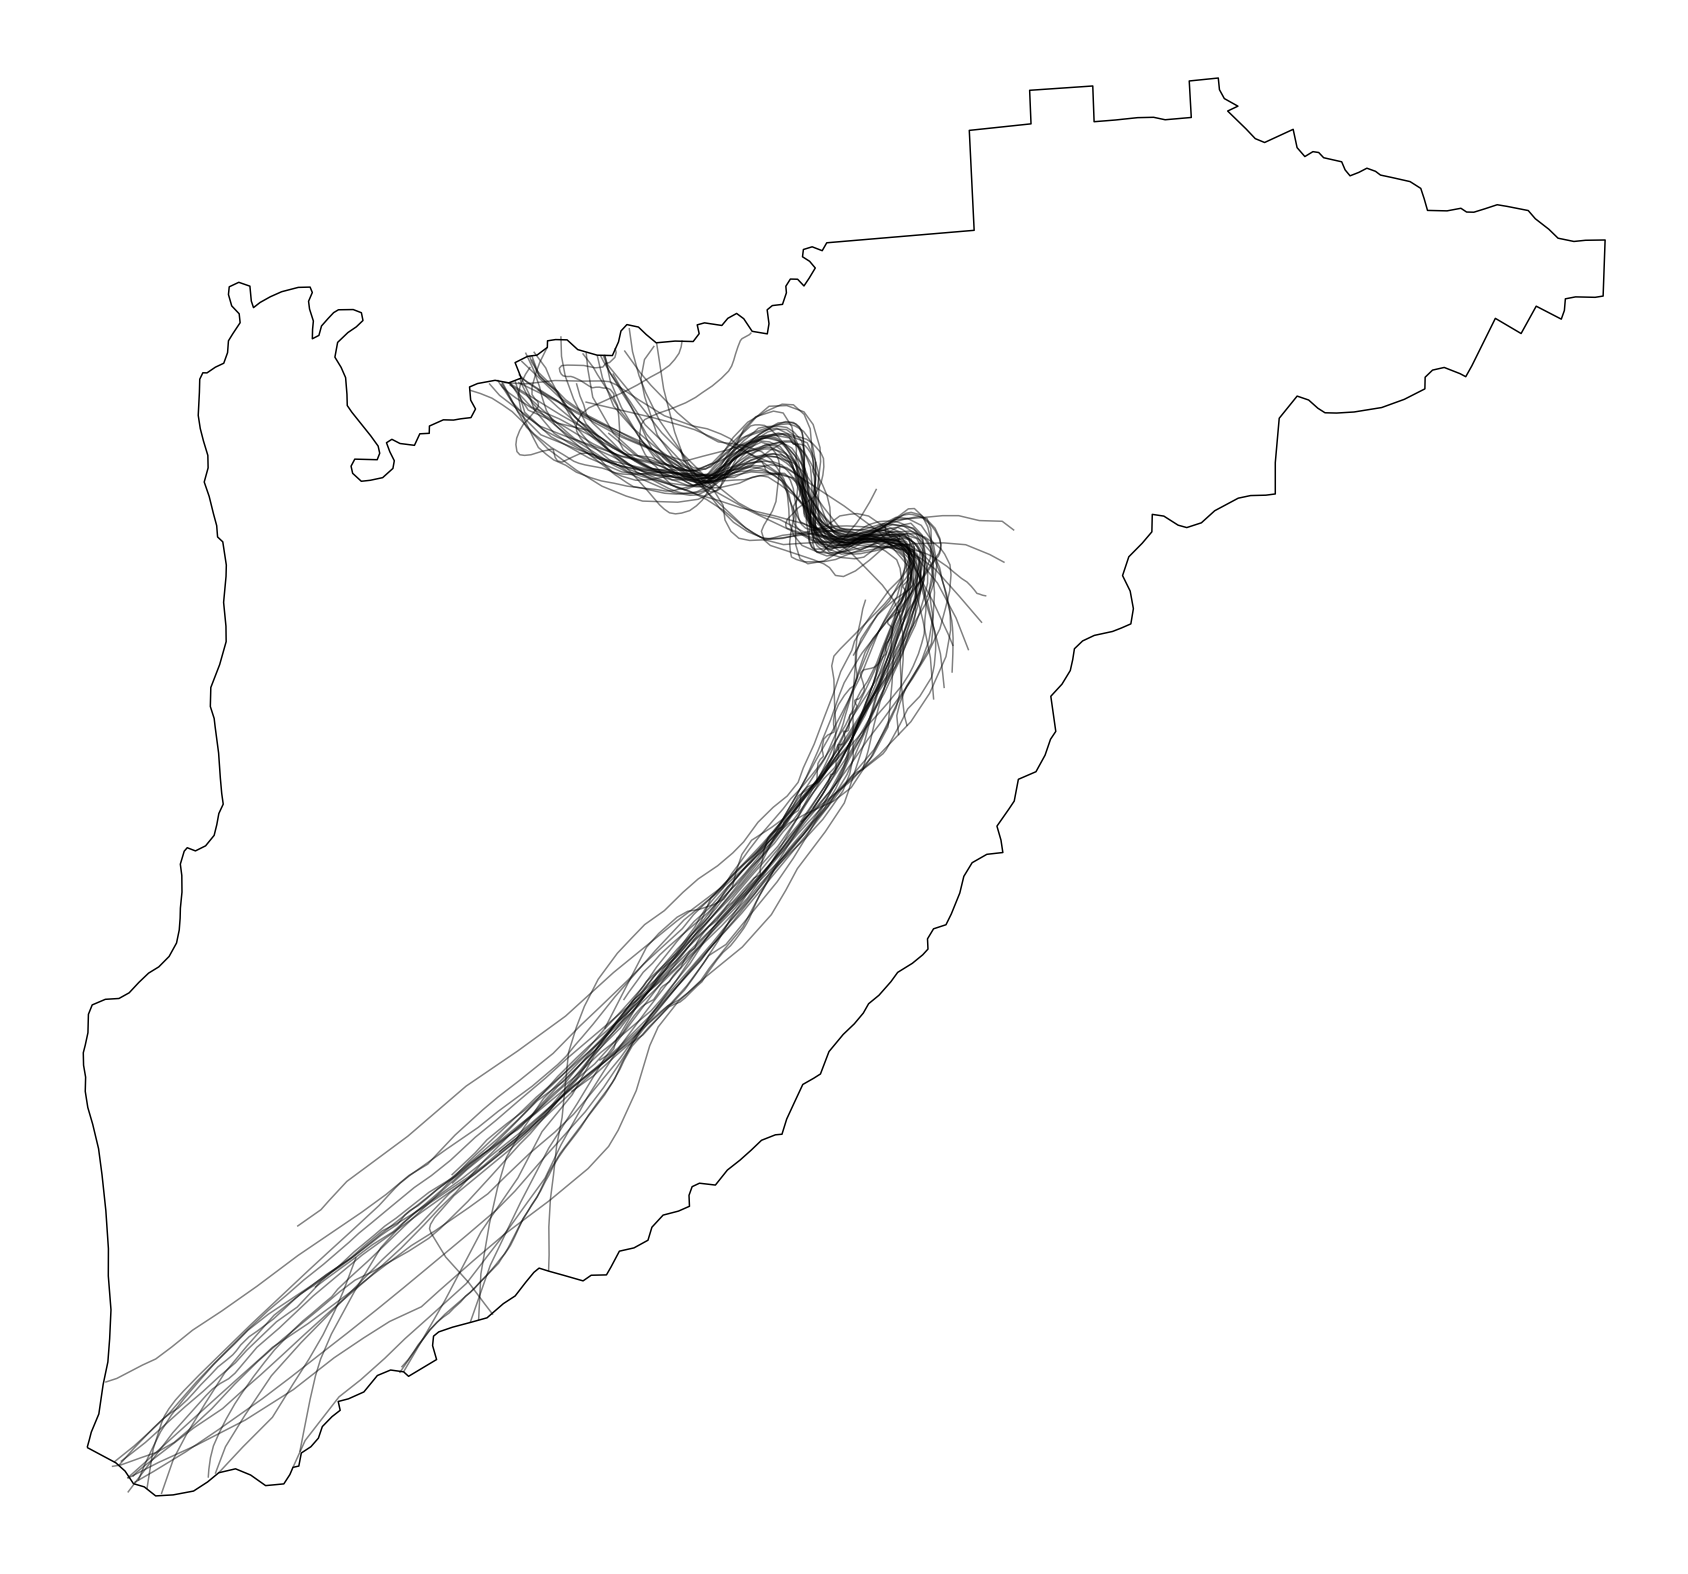

In [108]:
fig = plt.figure(figsize=(30,30), frameon=False)

ax1=fig.add_subplot(1,1,1)

study_area_shp.exterior.plot(ax=ax1, color="k", label="Study area")

contour_v = 80


for i in range(len(contour_shps_list)):
    #print(contour_shp_name_list[i])
    #print("i:%i"%i)
    c = "k"
    contour_shps_list[i][contour_shps_list[i]["Contour_m"]==contour_v].plot(ax=ax1, color=c, label="Contours", alpha=0.5)

ax=plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
    
nm = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper',
                     "80m_contours")

plt.savefig(nm, dpi=300)

# Plot regions of the figure to show variation

This figure is not very effective - the indiviual contours look better

In [114]:
for i in range(len(contour_shps_list)):

    print(i)
    print(contour_shp_name_list[i])
    print(contour_shps_list[i].columns)

0
ref_001_contours.shp
Index(['SHAPE_Leng', 'Contour_m', 'geometry'], dtype='object')
1
ref_002_contours.shp
Index(['SHAPE_Leng', 'Contour_m', 'geometry'], dtype='object')
2
ref_003_contours.shp
Index(['Contour_m', 'SHAPE_Leng', 'geometry'], dtype='object')
3
ref_004_contours.shp
Index(['Contour_m', 'SHAPE_Leng', 'Contour_m_', 'geometry'], dtype='object')
4
ref_005_contours.shp
Index(['Contour_m', 'SHAPE_Leng', 'Contour_m_', 'geometry'], dtype='object')
5
ref_008_contours.shp
Index(['Contour_m', 'SHAPE_Leng', 'geometry'], dtype='object')
6
ref_009_contours.shp
Index(['Contour_m', 'SHAPE_Leng', 'geometry'], dtype='object')
7
ref_012_contours.shp
Index(['Contour_m', 'SHAPE_Leng', 'Contour_m_', 'geometry'], dtype='object')
8
ref_012b_contours.shp
Index(['Contour_m', 'SHAPE_Leng', 'geometry'], dtype='object')
9
ref_014_contours.shp
Index(['Contour_m', 'SHAPE_Leng', 'geometry'], dtype='object')
10
ref_016_contours.shp
Index(['Contour_m', 'SHAPE_Leng', 'Contour_m_', 'geometry'], dtype='objec

(-35.23, -35.13)

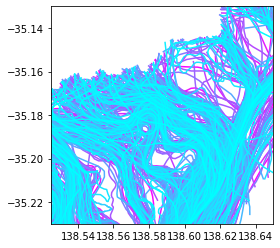

In [115]:
plt.figure()
ax1=plt.subplot(111)

colour = cm.cool_r(np.linspace(0, 1, len(contour_shps_list)))

for i in range(len(contour_shps_list)):
        #print(contour_shp_name_list[i])
        #print("i:%i"%i)
        c = colour[i]
        contour_shps_list[i].plot(ax=ax1, color=c, label="Contours")
        
plt.xlim([138.525, 138.65])
plt.ylim([-35.23, -35.13])
#ax1.invert_yaxis()

# TO DO: MAKE PLOT SHOWING SOME KEY TYPES - WHOLE MAPS

In [116]:
# Maps to include in a potential figure 
figslist = ["002" ,"012", "014", "026", "032", "033", "034", "R01"]

In [118]:
ix = 0
figs_ix = []
for i in range(len(names_list)):
    print(ix)
    nm = names_list[i][:-4]
    if nm in figslist:
        print(nm)
        figs_ix.append(ix)
    ix += 1
    
print(figs_ix)


0
1
002
2
3
4
5
6
7
012
8
9
014
10
11
12
13
14
15
026
16
17
18
19
20
032
21
033
22
034
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
R01
54
55
56
57
58
59
60
61
62
[1, 7, 9, 15, 20, 21, 22, 53]


In [119]:
from matplotlib import gridspec
gs = gridspec.GridSpec(2, 2, figure = fig,
                       wspace=0.1, hspace=0.1,
                       width_ratios=[1, 1], height_ratios=[1, 1]) 

In [120]:
gs[3]

GridSpec(2, 2)[1:2, 1:2]

<Figure size 2160x2160 with 0 Axes>

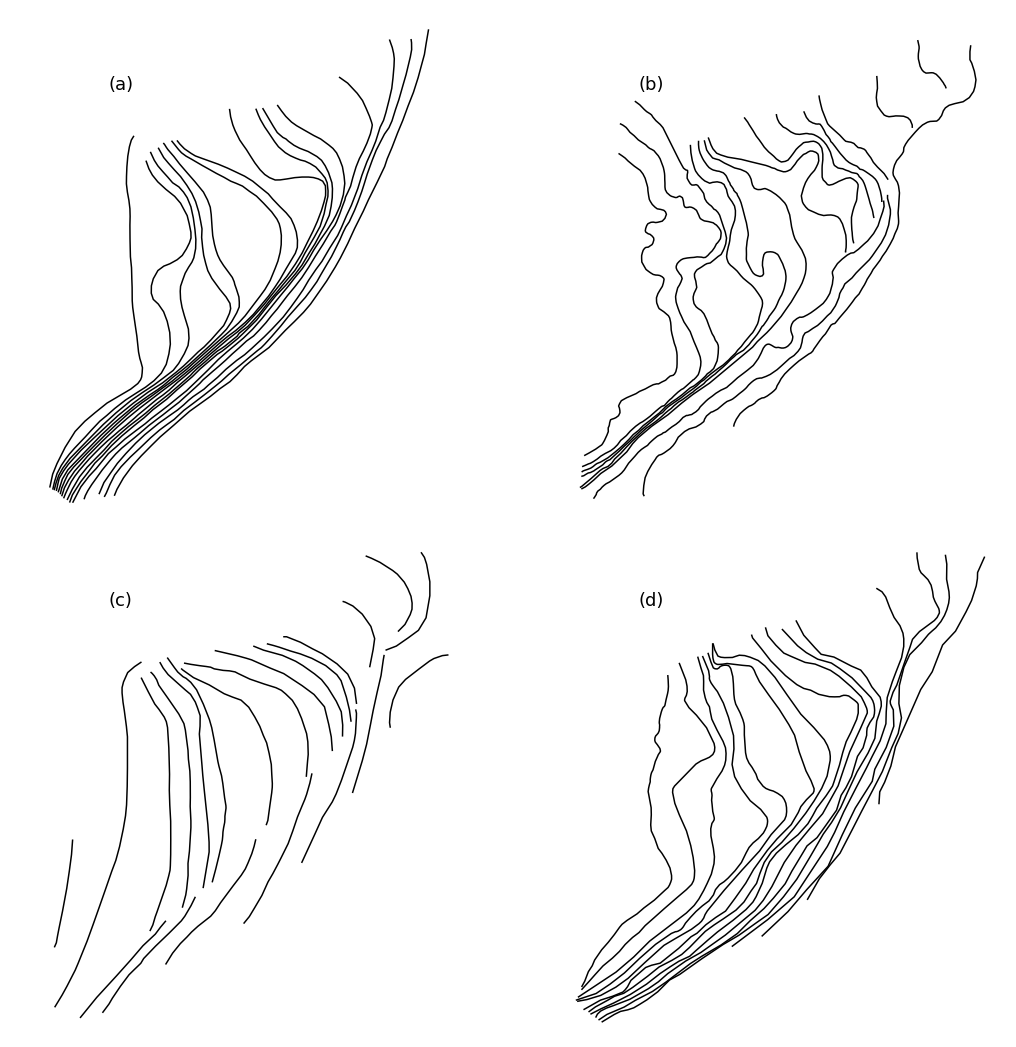

In [121]:
# Indexes of some interesting plots [1, 7, 9, 15, 19, 20, 21, 36]
fig = plt.figure(figsize=(30,30))
c = "k" # colour[i]
xlims = [138.42, 138.7]
ylims = [-35.36, -35.11]
visibility = False
letx = 138.48
lety = -35.15


# Using a colorbar to make the colours
colour = cm.cool_r(np.linspace(0, 1, 40))

#fig, axes = plt.subplots(2,2, figsize=(20,20))



fig = plt.figure(figsize=(19,19), frameon=False)

gs = gridspec.GridSpec(2, 2, figure = fig,
                       wspace=0.001, hspace=0.001,
                       width_ratios=[1, 1], height_ratios=[1, 1]) 

# First plot - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

i = 1#9
ax = plt.subplot(gs[0])        #axes[0][0]
contour_shps_list[i].plot(ax=ax, color=c, label="Contours")

ax.get_xaxis().set_visible(visibility)
ax.get_yaxis().set_visible(visibility)

plt.xlim(xlims)
plt.ylim(ylims)

plt.text(letx, lety, "(a)", fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Second plot - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

i = 20
ax = plt.subplot(gs[1])   #axes[0][1]
contour_shps_list[i].plot(ax=ax, color=c, label="Contours")

ax.get_xaxis().set_visible(visibility)
ax.get_yaxis().set_visible(visibility)

plt.xlim(xlims)
plt.ylim(ylims)

plt.text(letx, lety, "(b)", fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Third plot - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

i = 15
ax = plt.subplot(gs[2])   #axes[1][0]
contour_shps_list[i].plot(ax=ax, color=c, label="Contours")

ax.get_xaxis().set_visible(visibility)
ax.get_yaxis().set_visible(visibility)

plt.xlim(xlims)
plt.ylim(ylims)

plt.text(letx, lety, "(c)", fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


# Fourth plot - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

i = 36
ax = plt.subplot(gs[3])   #axes[1][1]
contour_shps_list[i].plot(ax=ax, color=c, label="Contours")

ax.get_xaxis().set_visible(visibility)
ax.get_yaxis().set_visible(visibility)

plt.xlim(xlims)
plt.ylim(ylims)

plt.text(letx, lety, "(d)", fontsize=18)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


# Formatting on the whole figure = = = = = = = = = = = = = = = = = = = = =
#plt.tight_layout()
#fig.subplots_adjust(hspace=.1, wspace=0.0)

fignm = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper', 'types')
plt.savefig(fignm, dpi=300)

# Get values at well indexes - CALIBRATE

In [122]:
a = df_well_ixs['letter'].unique()
print(type(a[0]))

<class 'float'>


In [123]:
# Data frame of values without letters
df_well_ixs_c = df_well_ixs[df_well_ixs['letter'].isna()]
df_well_ixs_c = df_well_ixs_c.copy()
df_well_ixs_c.index = df_well_ixs_c.DHNO

In [124]:
print(len(df_well_ixs_c))
print(len(df_well_ixs))

62
71


In [125]:
df_well_ixs_c.head()

DHNO   rswl    well_ix  well_ix_x  well_ix_y letter
DHNO                                                       
26558  26558   4.09  (186, 20)        186         20    NaN
26565  26565   4.33  (155, 40)        155         40    NaN
26585  26585  18.22  (144, 56)        144         56    NaN
27050  27050   5.54  (195, 50)        195         50    NaN
27063  27063  15.90  (217, 35)        217         35    NaN

In [126]:
arrays_list[i][50,50]
print(i)

36


In [127]:
calibrated_h_list = []
ar_name_list = []

for ar_i in range(len(arrays_list)):
        
    wt_ar = arrays_list[ar_i]
    nm = names_list[ar_i][:-4]
    well_hds = []

    plt.figure(figsize=(30,30))
    plt.imshow(wt_ar, cmap='rainbow')
    plt.colorbar()

    for ix in range(len(df_well_ixs_c)):
        xi = df_well_ixs_c.iloc[ix,3]
        yi = df_well_ixs_c.iloc[ix,4]
        h = wt_ar[xi, yi]
        plt.plot(yi,xi,"kx", markersize=10)
        plt.text(yi,xi,"%2.1f"%h, fontsize=15)

        well_hds.append(h)

    #print(well_hds)
    plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\rasters_with_wellvalues',
                            nm), dpi=300)
    plt.close()
    calibrated_h_list.append(well_hds)
    df_well_ixs_c[nm] = well_hds
    
    ar_name_list.append(nm)

In [128]:
df_well_ixs_c.columns

df_well_ixs_c['n'] = df_well_ixs_c[ar_name_list].count(axis=1)
df_well_ixs_c['mean'] = df_well_ixs_c[ar_name_list].mean(axis=1)
#df_well_ixs_c['sq_mean'] = df_well_ixs_c[ar_name_list].mean(axis=1)**2
#df_well_ixs_c['norm_mean'] = df_well_ixs_c[ar_name_list].mean(axis=1)/df_well_ixs_c['rswl']
#df_well_ixs_c['sq_norm_mean'] = df_well_ixs_c[ar_name_list].mean(axis=1)**2/df_well_ixs_c['rswl']**2


df_well_ixs_c['25th'] = df_well_ixs_c[ar_name_list].quantile(q=0.25,axis=1)
df_well_ixs_c['75th'] = df_well_ixs_c[ar_name_list].quantile(q=0.75,axis=1)

datanm = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\output_data',
                      "df_well_ixs_c.csv")
                      
df_well_ixs_c.to_csv(datanm)

# Plot difference between mean estimated value and rswl at "calibration" wells

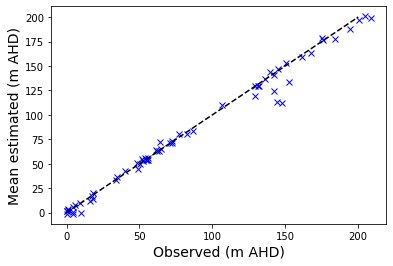

In [129]:
plt.plot(df_well_ixs_c['rswl'], df_well_ixs_c['mean'], "bx")
plt.xlabel("Observed (m AHD)", fontsize=14)
plt.ylabel("Mean estimated (m AHD)", fontsize=14)
plt.plot([0,200],[0,200], c="k", ls="--")

plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper',
                         "calibrated_obs_vs_est"))

# Calculate residuals

In [130]:
df_residuals = pd.DataFrame()
df_sq_residuals = pd.DataFrame()

for ar_i in range(len(ar_name_list)):
    
    nm = ar_name_list[ar_i]
    
    #print(nm)
    
    resid_column = []
    sq_resid_column = []
    
    for well_i in range(len(df_well_ixs_c)):
        rswl = df_well_ixs_c.loc[df_well_ixs_c.index[well_i], 'rswl']
        h_est = df_well_ixs_c.loc[df_well_ixs_c.index[well_i], nm]
        resid_column.append(h_est - rswl)
        sq_resid_column.append((h_est - rswl)**2)
        
    df_residuals[nm] = resid_column
    df_sq_residuals[nm] = sq_resid_column


In [131]:
df_residuals.head()

001        002        003       004        005       008       009  \
0 -24.293262 -22.147812 -11.653098 -1.134928 -13.727142 -5.352213  4.905111   
1  -2.587511  -3.364882   0.572679  0.917573  -4.831065  1.637878  4.542720   
2  -3.908103  -2.900313  -1.154391 -4.469781  -3.127524 -7.351429 -7.892585   
3   0.998256  -2.917102   3.561677  3.003658   3.060751 -0.518589  4.004954   
4  -5.383580  -3.115051  -4.220353 -3.425550  -2.113707 -2.055099 -3.967429   

         012      012b        014  ...       R01      R051      RS01  \
0  -3.535181       NaN -20.796440  ...  3.015227 -1.958449       NaN   
1   2.357495       NaN  -2.490521  ...  3.720916  1.559466  2.251695   
2  -1.727881 -2.471982  -3.526679  ... -6.212296 -7.544464 -4.563859   
3   0.948711  3.879268   3.138637  ...  2.739493  3.224072  2.702831   
4 -14.321672       NaN  -4.517824  ... -3.829355 -5.108832 -0.036927   

       SJ01     TV_001   UWA_001   UWA_002   UWA_003    U_1949      XZ01  
0  0.525174 -16.949505 -8.843154  0.720652 -5.123586       NaN -1.174240  
1  0.314110   1.873080  2.907988  2.529198  1.537774  3.233270  1.554896  
2 -4.151810  -3.414855 -1.918898 -3.720938 -0.338855 -5.275029 -4.016737  
3  3.374801   1.504753 -0.892612  5.290378  2.511178  3.401176  3.504769  
4 -4.587687  -4.502165 -9.961402 -2.053534 -4.239123 -5.657654 -5.873496  

[5 rows x 63 columns]

In [132]:
df_residuals.index = df_well_ixs_c.index
df_residuals.head()
df_sq_residuals.index = df_well_ixs_c.index

df_sq_residuals.head()

001         002         003        004         005        008  \
DHNO                                                                          
26558  590.162595  490.525565  135.794692   1.288061  188.434432  28.646189   
26565    6.695211   11.322433    0.327962   0.841941   23.339193   2.682645   
26585   15.273267    8.411816    1.332619  19.978939    9.781407  54.043504   
27050    0.996514    8.509483   12.685543   9.021963    9.368196   0.268935   
27063   28.982930    9.703541   17.811376  11.734392    4.467757   4.223432   

             009         012       012b         014  ...        R01  \
DHNO                                                 ...              
26558  24.060109   12.497507        NaN  432.491916  ...   9.091591   
26565  20.636303    5.557784        NaN    6.202693  ...  13.845214   
26585  62.292891    2.985573   6.110694   12.437463  ...  38.592624   
27050  16.039659    0.900053  15.048718    9.851039  ...   7.504824   
27063  15.740490  205.110295        NaN   20.410730  ...  14.663957   

            R051       RS01       SJ01      TV_001    UWA_001    UWA_002  \
DHNO                                                                       
26558   3.835523        NaN   0.275808  287.285710  78.201369   0.519339   
26565   2.431935   5.070129   0.098665    3.508429   8.456394   6.396841   
26585  56.918935  20.828806  17.237529   11.661233   3.682171  13.845383   
27050  10.394643   7.305297  11.389279    2.264280   0.796757  27.988095   
27063  26.100162   0.001364  21.046871   20.269492  99.229527   4.217002   

         UWA_003     U_1949       XZ01  
DHNO                                    
26558  26.251134        NaN   1.378841  
26565   2.364749  10.454032   2.417702  
26585   0.114822  27.825930  16.134174  
27050   6.306015  11.568001  12.283408  
27063  17.970162  32.009051  34.497960  

[5 rows x 63 columns]

In [133]:
# Residuals - - -
df_residuals['n'] = df_residuals[ar_name_list].count(axis=1)
df_residuals['mean'] = df_residuals[ar_name_list].mean(axis=1)
df_residuals['median'] = df_residuals[ar_name_list].median(axis=1)
df_residuals['sq_mean'] = df_residuals[ar_name_list].mean(axis=1)**2
df_residuals['norm_mean'] = df_residuals[ar_name_list].mean(axis=1)/df_well_ixs_c['rswl']
df_residuals['sq_norm_mean'] = df_residuals[ar_name_list].mean(axis=1)**2/df_well_ixs_c['rswl']**2
df_residuals['rt_sq_mean'] = np.sqrt(df_residuals[ar_name_list].mean(axis=1)**2)


df_residuals['25th'] = df_residuals[ar_name_list].quantile(q=0.25,axis=1)
df_residuals['75th'] = df_residuals[ar_name_list].quantile(q=0.75,axis=1)

# Squared residuals - - - 
df_sq_residuals['n'] = df_sq_residuals[ar_name_list].count(axis=1)
df_sq_residuals['mean'] = df_sq_residuals[ar_name_list].mean(axis=1)
df_sq_residuals['sq_mean'] = df_sq_residuals[ar_name_list].mean(axis=1)**2
df_sq_residuals['norm_mean'] = df_sq_residuals[ar_name_list].mean(axis=1)/df_well_ixs_c['rswl']
df_sq_residuals['sq_norm_mean'] = df_sq_residuals[ar_name_list].mean(axis=1)**2/df_well_ixs_c['rswl']**2
df_sq_residuals['root_sq_norm_mean'] = np.sqrt(df_sq_residuals['sq_norm_mean'])

df_sq_residuals['25th'] = df_sq_residuals[ar_name_list].quantile(q=0.25,axis=1)
df_sq_residuals['75th'] = df_sq_residuals[ar_name_list].quantile(q=0.75,axis=1)

# Plot mean residuals

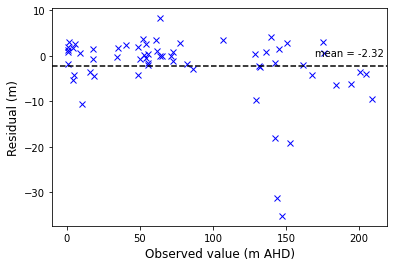

In [134]:
plt.plot(df_well_ixs_c['rswl'], df_residuals['mean'], "bx")

mean_r = df_residuals['mean'].mean()

plt.axhline(y=mean_r, ls="--", color="k")
plt.xlabel("Observed value (m AHD)", fontsize=12)
plt.ylabel("Residual (m)", fontsize=12)
plt.text(170, 0, "mean = %2.2f" %mean_r)

plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper',
                         "residuals"), dpi=300)

## Histograms of residuals per bore

In [158]:
i = 0 # Index
    
df = df_residuals[ar_name_list].transpose()

for i in range(len(df_residuals)):
    plt.figure()
    df[df_residuals.index[i]].hist(label="Bore ID: %s"%df_residuals.index[i], color="0.5", bins=20)

    plt.axvline(df_residuals.loc[df_residuals.index[i], "mean"], ls="--", c="k", label="mean")
    plt.axvline(df_residuals.loc[df_residuals.index[i], "median"], ls="--", c="g", label="median")
    plt.axvline(df_residuals.loc[df_residuals.index[i], "25th"], ls="--", c="m", label="25th to 75th")
    plt.axvline(df_residuals.loc[df_residuals.index[i], "75th"], ls="--", c="m")

    plt.legend()

    fignm = os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\residuals_per_map',
                         df_residuals.index[i])
    
    plt.savefig(fignm, dpi=300)
    plt.close()

## Plot mean residuals but with the range for each point
## Plot as boxplots


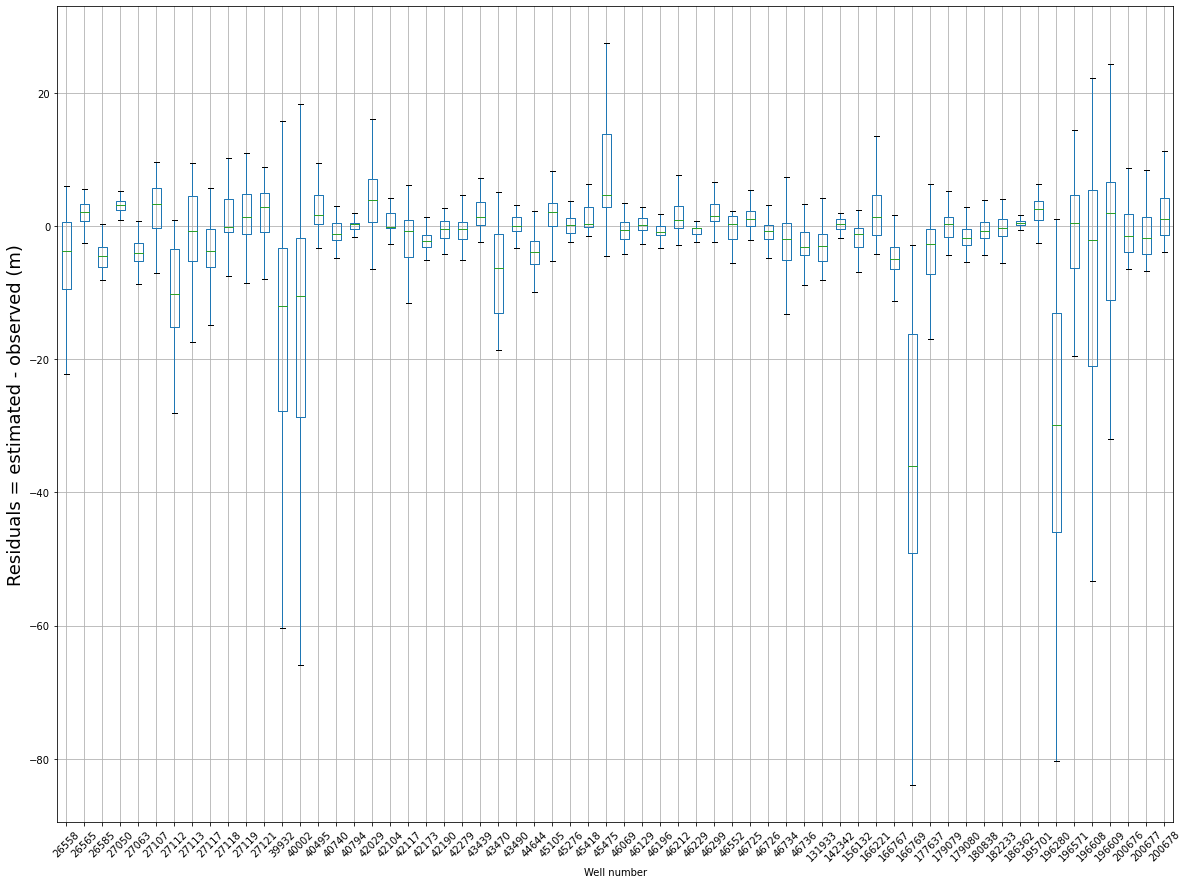

In [159]:
plt.figure(figsize=(20,15))
df_residuals[ar_name_list[1:]].transpose().boxplot(rot=45, showfliers=False)
plt.xlabel("Well number")
plt.ylabel("Residuals = estimated - observed (m)", fontsize=18)
plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper',
                         "resid_well_bplot"), dpi=300)



# Here ix = rswl, could change to using df_residuals.loc[ix, 'rswl'] if not (or other way around)

for i in range(len(df_residuals)):
    ix = df_residuals.index[i]
    print(i,ix)
    print(df_residuals.loc[ix, 'rswl'])
    plt.plot([df_residuals.loc[ix, 'rswl'], df_residuals.loc[ix, 'rswl']], 
             [df_residuals.loc[ix, '25th'],df_residuals.loc[ix, '75th']],
             ls="-", c="dodgerblue", alpha=0.5, lw=3)

plt.plot(df_residuals['rswl'], df_residuals['mean'], "bx")

mean_r = df_residuals['median'].mean()
plt.axhline(y=mean_r, ls="--", color="k")

for i in range(len(df_residuals)):
    ix = df_residuals.index[i]
    #print(i,ix)
    #print(df_residuals.loc[ix, 'rswl'])
    plt.plot([df_residuals.loc[ix, 'rswl'], df_residuals.loc[ix, 'rswl']], 
             [df_residuals.loc[ix, '25th'],df_residuals.loc[ix, '75th']],
             ls="-", c="dodgerblue", alpha=0.5, lw=3)

plt.xlabel("Observed value (m AHD)", fontsize=12)
plt.ylabel("Residual (m)", fontsize=12)
#plt.text(170, 0, "mean = %2.2f" %mean_r)

plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper',
                         "residuals_range"), dpi=300)

# Add rswl column to residuals for plotting

In [160]:
if "rswl" in df_residuals.columns:
    pass
else:
    df_residuals = df_residuals.join(df_well_ixs_c['rswl'], on=df_residuals.index)



# Sort by order of rswl - YOU CANNOT SORT IF YOU HAVE ALREADY MADE IT THE INDEX!!
# It looks like you can if I used code: sort_index - but what I have done below works instead (an order thing)

In [161]:
a = df_residuals
a.index
df_residuals = df_residuals.sort_values(by="rswl")

df_residuals_r = df_residuals.copy()
df_residuals_r.index = df_residuals_r.rswl

In [162]:
df_residuals_r.head()

001        002        003       004       005       008       009  \
rswl                                                                            
0.45  -9.036944 -11.029639  -2.932006  3.824889 -0.296792 -0.438003 -1.187815   
0.50  -9.283926 -13.530401  -1.609569  5.113712 -1.552745 -1.303133  1.586114   
0.55 -17.619902 -16.635562 -10.130538  0.593201 -4.290741 -0.219174       NaN   
0.98  -8.315455 -14.455607   0.496156  4.726823 -0.152304 -0.951767  7.463899   
1.12   0.755614   2.304207  -0.172239  1.561395  0.749876  6.062506       NaN   

           012  012b        014  ...   n      mean    median   sq_mean  \
rswl                             ...                                     
0.45 -0.450935   NaN  -8.550685  ...  55  0.836416 -0.185601  0.699591   
0.50 -0.367076   NaN  -8.540041  ...  55  1.237993  1.386490  1.532628   
0.55       NaN   NaN -14.533470  ...  49 -1.839882 -0.987306  3.385167   
0.98 -0.225069   NaN  -7.071140  ...  55  1.852306  3.092719  3.431036   
1.12       NaN   NaN  -3.174708  ...  47  3.002236  2.449497  9.013422   

      norm_mean  sq_norm_mean  rt_sq_mean      25th      75th  rswl  
rswl                                                                 
0.45   1.858701      3.454770    0.836416 -0.934307  3.949498  0.45  
0.50   2.475987      6.130511    1.237993 -1.264522  4.663116  0.50  
0.55  -3.345241     11.190635    1.839882 -5.457499  4.372346  0.55  
0.98   1.890108      3.572508    1.852306 -0.258039  5.548849  0.98  
1.12   2.680568      7.185445    3.002236 -0.771126  5.037558  1.12  

[5 rows x 73 columns]

## Plot boxplot of residuals per well in order of rswl

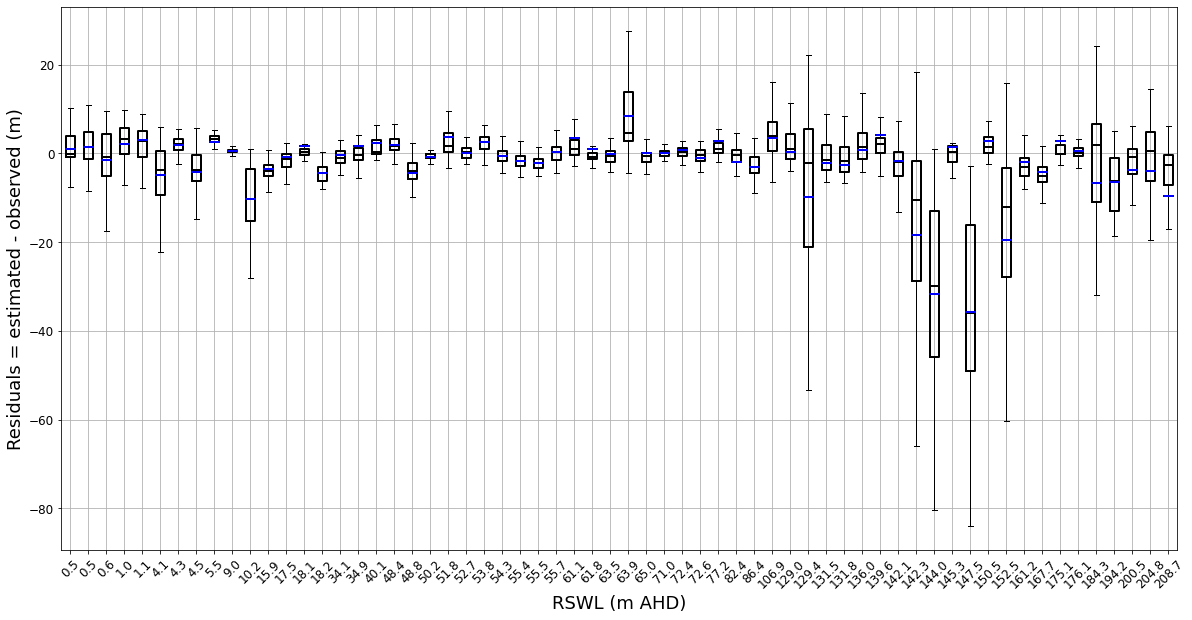

In [163]:
boxprops = dict(linestyle='-', linewidth=2, color="k")
medianprops = dict(linestyle='-', linewidth=2, color="k")
meanpointprops = dict(marker='.', markeredgecolor= "r", markerfacecolor = "r")
meanlineprops = dict(linestyle='-', linewidth=2, color='b')

colours = dict(boxes='k', whiskers='k', medians='k', caps='k')

plt.figure(figsize=(20,10))
df_residuals_r[ar_name_list[1:]].transpose().boxplot(rot=45, showfliers=False, showmeans=True, 
                                                     boxprops=boxprops, medianprops=medianprops,
                                                     meanline=True,meanprops=meanlineprops,  #meanpointprops,
                                                     color = colours,
                                                     fontsize=12, )
#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

# Changing the number of decimal points in the xlabels
ax = plt.gca()
labels = [item.get_text() for item in plt.gca().get_xticklabels()]
ax.set_xticklabels([str(round(float(label), 1)) for label in labels])


# Plot formatting
plt.xlabel("RSWL (m AHD)", fontsize=18)
plt.ylabel("Residuals = estimated - observed (m)", fontsize=18)

# Save the figure
plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper',
                         "resid_well_bplot_rswl"), dpi=300)



## Plot mean squared residuals

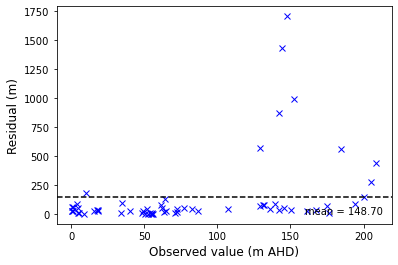

In [164]:
plt.plot(df_well_ixs_c['rswl'], df_sq_residuals['mean'], "bx")

mean_r = df_sq_residuals['mean'].mean()

plt.axhline(y=mean_r, ls="--", color="k")
plt.xlabel("Observed value (m AHD)", fontsize=12)
plt.ylabel("Residual (m)", fontsize=12)
plt.text(160, 0, "mean = %2.2f" %mean_r)

plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper',
                         "residuals2"), dpi=300)

## Plot root mean squared residuals

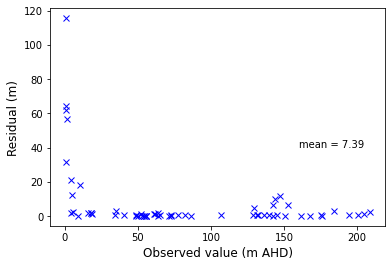

In [165]:
plt.plot(df_well_ixs_c['rswl'], df_sq_residuals['root_sq_norm_mean'], "bx")

mean_r = df_sq_residuals['root_sq_norm_mean'].mean()

#plt.axhline(y=mean_r, ls="--", color="k")
plt.xlabel("Observed value (m AHD)", fontsize=12)
plt.ylabel("Residual (m)", fontsize=12)
plt.text(160, 40, "mean = %2.2f" %mean_r)

plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper',
                         "residuals_rmse"), dpi=300)

## Residuals boxplots - per map

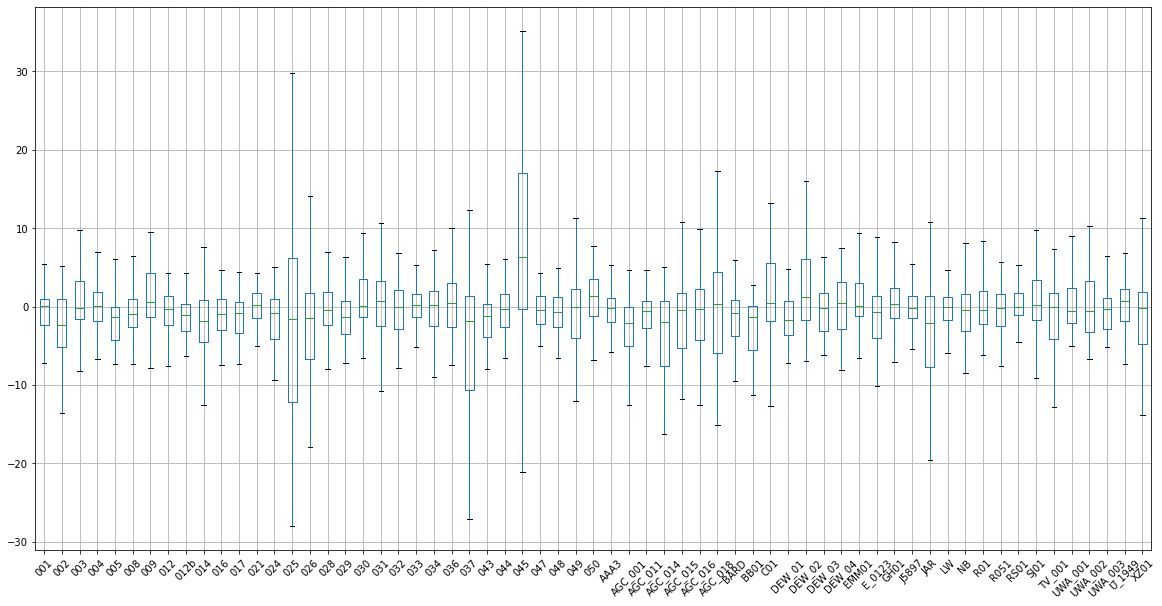

In [170]:
plt.figure(figsize=(20,10))
df_residuals[ar_name_list].boxplot(rot=45, showfliers=False)
plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper',
                         "resid_map_bplot"), dpi=300)

## Histogram - average error per map

In [215]:
rmse_per_map = []

for i in range(len(ar_name_list)):
    a = df_residuals[ar_name_list[i]]
    rmse_per_map.append(np.sqrt((a**2).sum()/a.count()).mean())
    

In [216]:
print("Average calibration RMSE per well and per map: %2.2f"%np.mean(rmse_per_map))
print("Median calibration RMSE per well and per map: %2.2f"%np.median(rmse_per_map))

Average calibration RMSE per well and per map: 10.48
Median calibration RMSE per well and per map: 10.58


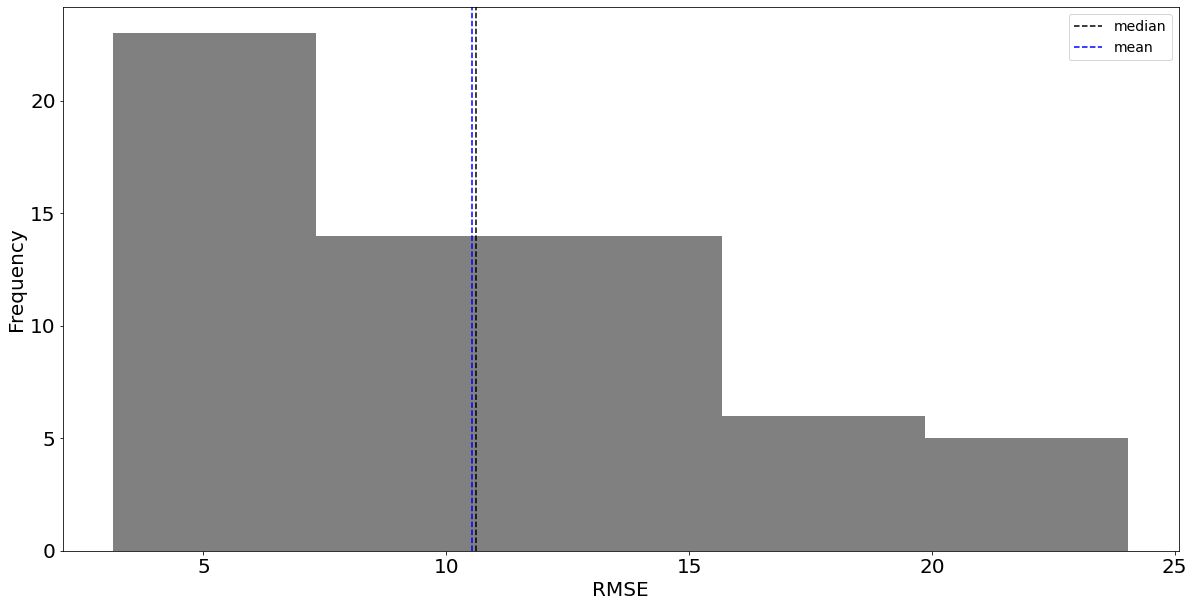

In [173]:
plt.figure(figsize=(20,10))
plt.hist(rmse_per_map, density=False, bins=5, color="0.5")
plt.axvline(np.median(rmse_per_map), ls='--', color="k", label="median")
plt.axvline(np.mean(rmse_per_map), ls='--', color="b", label="mean")
plt.gca().tick_params(axis='both', which='major', labelsize=20)

plt.legend(fontsize=14)

plt.xlabel("RMSE", fontsize=20)
plt.ylabel("Frequency", fontsize=20)

# Could change bins more regular
plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper',
                         "rmse_per_map_hist"), dpi=300)

# Re-do standard deviation figure with the mean cailbration residual values 

In [174]:
df_residuals.head()
#df_well_ixs_c.head()

001        002        003       004       005       008  \
DHNO                                                                   
27118  -9.036944 -11.029639  -2.932006  3.824889 -0.296792 -0.438003   
27119  -9.283926 -13.530401  -1.609569  5.113712 -1.552745 -1.303133   
27113 -17.619902 -16.635562 -10.130538  0.593201 -4.290741 -0.219174   
27107  -8.315455 -14.455607   0.496156  4.726823 -0.152304 -0.951767   
27121   0.755614   2.304207  -0.172239  1.561395  0.749876  6.062506   

            009       012  012b        014  ...   n      mean    median  \
DHNO                                        ...                           
27118 -1.187815 -0.450935   NaN  -8.550685  ...  55  0.836416 -0.185601   
27119  1.586114 -0.367076   NaN  -8.540041  ...  55  1.237993  1.386490   
27113       NaN       NaN   NaN -14.533470  ...  49 -1.839882 -0.987306   
27107  7.463899 -0.225069   NaN  -7.071140  ...  55  1.852306  3.092719   
27121       NaN       NaN   NaN  -3.174708  ...  47  3.002236  2.449497   

        sq_mean  norm_mean  sq_norm_mean  rt_sq_mean      25th      75th  rswl  
DHNO                                                                            
27118  0.699591   1.858701      3.454770    0.836416 -0.934307  3.949498  0.45  
27119  1.532628   2.475987      6.130511    1.237993 -1.264522  4.663116  0.50  
27113  3.385167  -3.345241     11.190635    1.839882 -5.457499  4.372346  0.55  
27107  3.431036   1.890108      3.572508    1.852306 -0.258039  5.548849  0.98  
27121  9.013422   2.680568      7.185445    3.002236 -0.771126  5.037558  1.12  

[5 rows x 73 columns]

In [175]:
# Rename mean from residuals so I know its residual mean when I add it to the other dataframe
df_residuals = df_residuals.rename(columns={"mean": "res_mean", "rt_sq_mean": "res_rt_sq_mn"})
df_residuals.head()

001        002        003       004       005       008  \
DHNO                                                                   
27118  -9.036944 -11.029639  -2.932006  3.824889 -0.296792 -0.438003   
27119  -9.283926 -13.530401  -1.609569  5.113712 -1.552745 -1.303133   
27113 -17.619902 -16.635562 -10.130538  0.593201 -4.290741 -0.219174   
27107  -8.315455 -14.455607   0.496156  4.726823 -0.152304 -0.951767   
27121   0.755614   2.304207  -0.172239  1.561395  0.749876  6.062506   

            009       012  012b        014  ...   n  res_mean    median  \
DHNO                                        ...                           
27118 -1.187815 -0.450935   NaN  -8.550685  ...  55  0.836416 -0.185601   
27119  1.586114 -0.367076   NaN  -8.540041  ...  55  1.237993  1.386490   
27113       NaN       NaN   NaN -14.533470  ...  49 -1.839882 -0.987306   
27107  7.463899 -0.225069   NaN  -7.071140  ...  55  1.852306  3.092719   
27121       NaN       NaN   NaN  -3.174708  ...  47  3.002236  2.449497   

        sq_mean  norm_mean  sq_norm_mean  res_rt_sq_mn      25th      75th  \
DHNO                                                                         
27118  0.699591   1.858701      3.454770      0.836416 -0.934307  3.949498   
27119  1.532628   2.475987      6.130511      1.237993 -1.264522  4.663116   
27113  3.385167  -3.345241     11.190635      1.839882 -5.457499  4.372346   
27107  3.431036   1.890108      3.572508      1.852306 -0.258039  5.548849   
27121  9.013422   2.680568      7.185445      3.002236 -0.771126  5.037558   

       rswl  
DHNO         
27118  0.45  
27119  0.50  
27113  0.55  
27107  0.98  
27121  1.12  

[5 rows x 73 columns]

In [176]:
if "res_mean" in df_well_ixs_c.columns:
    pass
else:
    df_well_ixs_c = df_well_ixs_c.join(df_residuals['res_mean'], on=df_residuals.index)


In [177]:
if "res_rt_sq_mn" in df_well_ixs_c.columns:
    pass
else:
    df_well_ixs_c = df_well_ixs_c.join(df_residuals['res_rt_sq_mn'], on=df_residuals.index)


In [178]:
df_well_ixs_c.head()

DHNO   rswl    well_ix  well_ix_x  well_ix_y letter        001  \
DHNO                                                                     
26558  26558   4.09  (186, 20)        186         20    NaN -20.203262   
26565  26565   4.33  (155, 40)        155         40    NaN   1.742489   
26585  26585  18.22  (144, 56)        144         56    NaN  14.311897   
27050  27050   5.54  (195, 50)        195         50    NaN   6.538256   
27063  27063  15.90  (217, 35)        217         35    NaN  10.516420   

             002        003        004  ...    UWA_002    UWA_003     U_1949  \
DHNO                                    ...                                    
26558 -18.057812  -7.563098   2.955072  ...   4.810652  -1.033586        NaN   
26565   0.965118   4.902679   5.247573  ...   6.859198   5.867774   7.563270   
26585  15.319687  17.065609  13.750219  ...  14.499062  17.881145  12.944971   
27050   2.622898   9.101677   8.543658  ...  10.830378   8.051178   8.941176   
27063  12.784949  11.679647  12.474450  ...  13.846466  11.660877  10.242346   

            XZ01   n       mean       25th       75th  res_mean  res_rt_sq_mn  
DHNO                                                                           
26558   2.915760  54  -1.157317  -5.521735   4.638394  0.836416      0.836416  
26565   5.884896  59   6.055026   4.999494   7.635187  1.237993      1.237993  
26585  14.203263  63  13.722613  12.027284  15.145957 -1.839882      1.839882  
27050   9.044769  63   8.160018   7.991015   9.369665  1.852306      1.852306  
27063  10.026504  62  12.297091  10.691167  13.359565  3.002236      3.002236  

[5 rows x 75 columns]

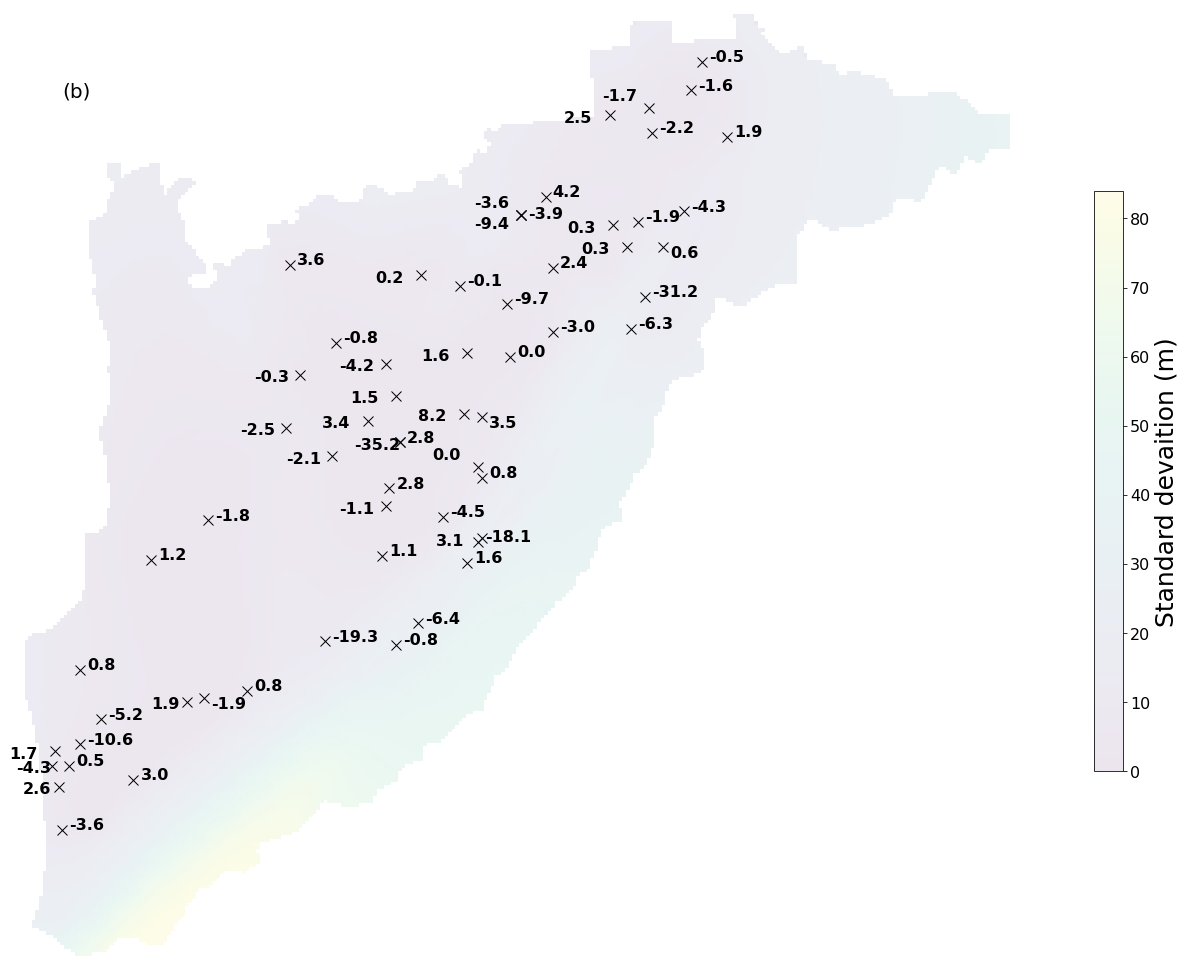

In [179]:
plt.figure(figsize=(20,20))

axes=plt.subplot(111, frameon=False)

m = plt.imshow(std_array, cmap='viridis', alpha=0.1)
#cs = plt.contour(std_array, colors="k", linewidths=1)
plt.clabel(cs, inline=1, fontsize=14, fmt='%1i', colors="k")
cb = plt.colorbar(m, fraction=0.026, pad=0.06)

axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

for t in cb.ax.get_yticklabels():
     t.set_fontsize(16)
        
cb.set_label("Standard devaition (m)", fontsize=25)


ii = 0
for i in range(len(df_well_ixs_c.index)):
    ix = df_well_ixs_c.index[i]
    y = df_well_ixs_c.loc[ix,"well_ix_x"]
    x = df_well_ixs_c.loc[ix,"well_ix_y"]
    letter = df_well_ixs_c.loc[ix,"letter"]
    value_r = df_well_ixs_c.loc[ix,"res_mean"]
    plt.plot(x,y,'x',c='k', markersize=10, label='_nolegend_')
    if ii in [39, 53, 56]:
        # Bottom right
        #plt.text(x+2,y+3,"%i:%2.1f"%(ii,value_r), fontsize=16, fontweight='bold',c="k")
        plt.text(x+2,y+3,"%2.1f"%(value_r), fontsize=16, fontweight='bold',c="k")

        # Left 
    elif ii in [6, 15, 22, 23, 26, 27, 28, 31, 35, 16, 40, 43, 49, 50, 54, 55]:
        plt.text(x-13,y+2,"%2.1f"%(value_r), fontsize=16, fontweight='bold',c="k")
        
            # Left close
    elif ii in [3, 7, 8]:
        plt.text(x-10,y+2,"%2.1f"%(value_r), fontsize=16, fontweight='bold',c="k")
        
        # Left down 
    elif ii in [61]:
        plt.text(x-13,y+4,"%2.1f"%(value_r), fontsize=16, fontweight='bold',c="k")
        
        # Right
    elif ii in [60]:
        plt.text(x+2, y+1,"%2.1f"%(value_r), fontsize=16, fontweight='bold',c="k")
        
        # Left up 
    elif ii in [22, 33, 46, 59]:
        plt.text(x-13,y-2,"%2.1f"%(value_r), fontsize=16, fontweight='bold',c="k")
        
    else:
        # Right up
        #plt.text(x,y-3,"%i:%2.1f"%(ii,value_r), fontsize=16, fontweight='bold',c="k")
        plt.text(x+2,y+0,"%2.1f"%(value_r), fontsize=16, fontweight='bold',c="k")
    ii +=1
    
#axes.plot(x,y, "kx", alpha=1, markersize=10, label="Hydraulic head measurement")    
#plt.legend(frameon=False, fontsize=18, loc=4)

plt.text(15,25, "(b)", fontsize=20)

nm = os.path.join(figure_directory, "std_c")
#plt.savefig(nm, dpi=300)

# Spatial plot where the residuals are coloured 

In [180]:

upr = df_well_ixs_c["res_mean"].max()
print(upr)
lwr = df_well_ixs_c["res_mean"].min()
print(lwr)
print(max([abs(upr),abs(lwr)]))

rangecol = max([abs(upr),abs(lwr)])*2 #upr - lwr

# Create a new upper and lower - because I want to use the absolute values so it's symmetrical

upr = max([abs(upr),abs(lwr)])
lwr = -max([abs(upr),abs(lwr)])

print(rangecol)
colour = cm.seismic(np.linspace(0, 1, int(rangecol+1)*100)) # coolwarm_r
print(int(rangecol+1)*100)

8.242927028111051
-35.2222428339178
35.2222428339178
70.4444856678356
7100


In [181]:
value_r = 40.5

int((value_r - lwr)*100)

7572

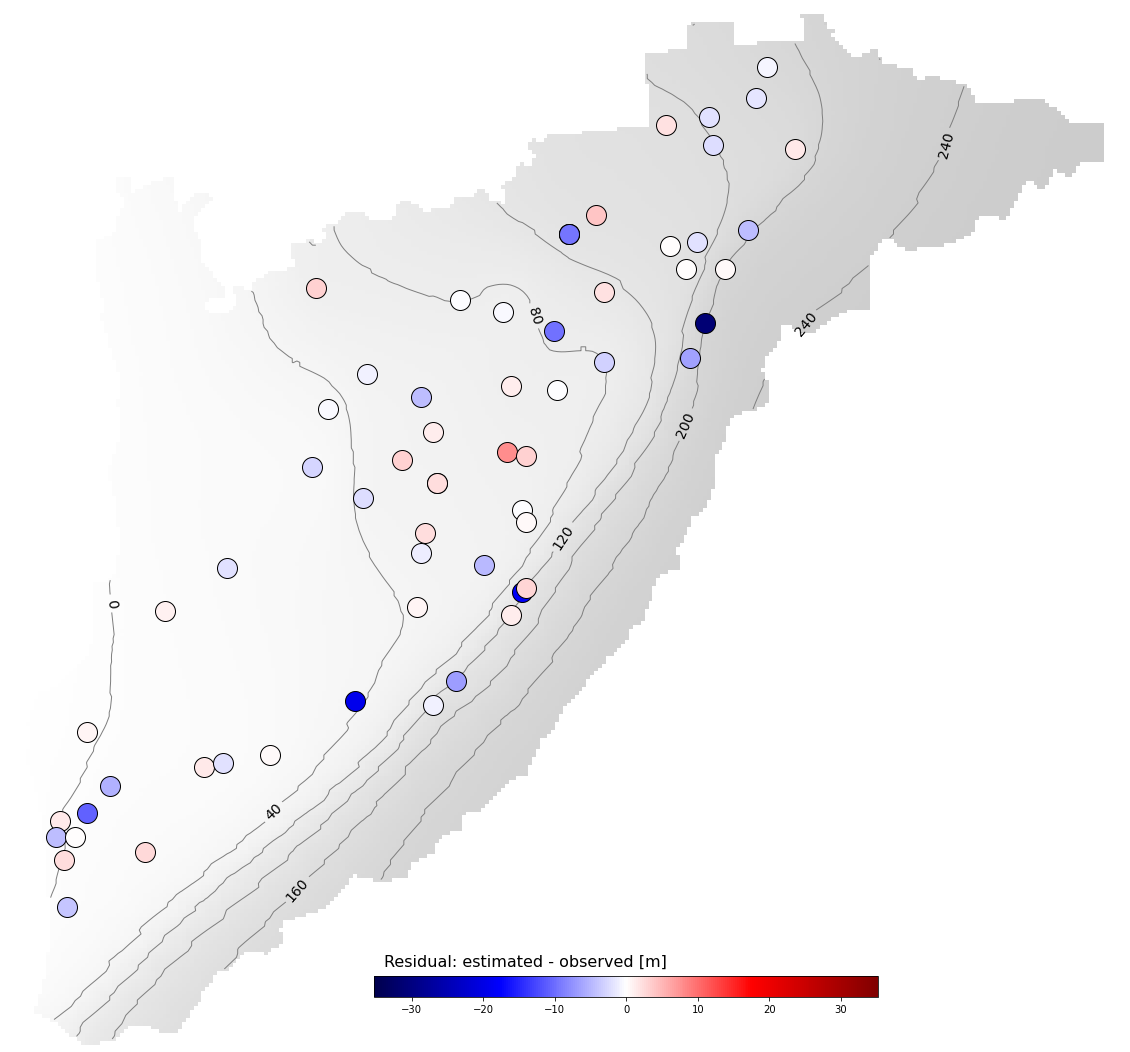

In [182]:
fig = plt.figure(figsize=(20,20))

axes=plt.subplot(111, frameon=False)

m = plt.imshow(mean_array, cmap='gist_gray_r', alpha=0.2)
cs = plt.contour(mean_array, colors="0.5", linewidths=1)
plt.clabel(cs, inline=1, fontsize=14, fmt='%1i', colors="k")
#cb = plt.colorbar(m, fraction=0.026, pad=0.06)

axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

for t in cb.ax.get_yticklabels():
     t.set_fontsize(16)
        
cb.set_label("Standard devaition (m)", fontsize=25)


ii = 0
for i in range(len(df_well_ixs_c.index)):
    ix = df_well_ixs_c.index[i]
    y = df_well_ixs_c.loc[ix,"well_ix_x"]
    x = df_well_ixs_c.loc[ix,"well_ix_y"]
    letter = df_well_ixs_c.loc[ix,"letter"]
    value_r = df_well_ixs_c.loc[ix,"res_mean"]
    
    # Make the colour according to the value of the residual
    c = "k"
    c = colour[int((value_r - lwr)*100)]
    
    # Plotting the markers
    plt.plot(x,y,'o',c=c, markersize=20, markeredgecolor="k", label='_nolegend_')
    #plt.text(x+2,y+3,"%2.1f"%(value_r), fontsize=16, fontweight='bold',c="k")

    
# Colourbar for the residuals
plt.subplots_adjust(top = 0.93, hspace=0.3, wspace=0.1) # , bottom=0.01, 
cmap = mpl.cm.ScalarMappable(
      norm = mcolors.Normalize(lwr, upr), 
      cmap = plt.get_cmap('seismic'))

cbaxes1 = fig.add_axes([0.38, 0.2, 0.35, 0.015]) 
cmap.set_array([])
cb = fig.colorbar(cmap,  cax=cbaxes1, orientation="horizontal")
cb.set_label("Residual: estimated - observed [m]", labelpad=-60, x=0.3, y=10, fontsize=16)
    
#axes.plot(x,y, "kx", alpha=1, markersize=10, label="Hydraulic head measurement")    
#plt.legend(frameon=False, fontsize=18, loc=4)

#plt.text(15,25, "(b)", fontsize=20)

nm = os.path.join(figure_directory, "map_residuals")
plt.savefig(nm, dpi=300)

# PREDICTION DATA -----------------------------------------------

# Make a dataframe with the prediction data only

In [183]:
df_well_ixs_p = df_well_ixs[~df_well_ixs['letter'].isna()].copy()
df_well_ixs_p.index = df_well_ixs_p.DHNO
df_well_ixs_p.head(10)

DHNO    rswl     well_ix  well_ix_x  well_ix_y letter
DHNO                                                           
27125    27125   16.11   (197, 17)        197         17      a
39875    39875   35.77   (215, 66)        215         66      b
42108    42108  166.65   (36, 185)         36        185      i
46232    46232   70.07  (107, 154)        107        154      h
180822  180822   55.58  (109, 109)        109        109      f
new1      new1     NaN   (182, 36)        182         36      c
new2      new2     NaN  (119, 156)        119        156      g
new3      new3     NaN   (155, 53)        155         53      d
new4      new4     NaN    (68, 34)         68         34      e

# Make a dataframe with prediction only where we have observed value

In [184]:
df_well_ixs_p1 = df_well_ixs_p[~df_well_ixs_p['rswl'].isna()].copy()
df_well_ixs_p1.index = df_well_ixs_p1.DHNO
df_well_ixs_p1.head()

DHNO    rswl     well_ix  well_ix_x  well_ix_y letter
DHNO                                                           
27125    27125   16.11   (197, 17)        197         17      a
39875    39875   35.77   (215, 66)        215         66      b
42108    42108  166.65   (36, 185)         36        185      i
46232    46232   70.07  (107, 154)        107        154      h
180822  180822   55.58  (109, 109)        109        109      f

# Make a dataframe with prediction only where we don't have an observed value

In [185]:
df_well_ixs_p2 = df_well_ixs_p[df_well_ixs_p['rswl'].isna()].copy()
df_well_ixs_p2.index = df_well_ixs_p2.DHNO
df_well_ixs_p2.head()

DHNO  rswl     well_ix  well_ix_x  well_ix_y letter
DHNO                                                     
new1  new1   NaN   (182, 36)        182         36      c
new2  new2   NaN  (119, 156)        119        156      g
new3  new3   NaN   (155, 53)        155         53      d
new4  new4   NaN    (68, 34)         68         34      e

# Get all the values from the maps

In [186]:
len(df_well_ixs_p1)

5

In [187]:
calibrated_h_list_p = []

for ar_i in range(len(arrays_list)):
        
    wt_ar = arrays_list[ar_i]
    nm = names_list[ar_i][:-4]
    well_hds = []

    plt.figure(figsize=(30,30))
    plt.imshow(wt_ar, cmap='rainbow')
    plt.colorbar()

    for i in range(len(df_well_ixs_p1)):
        ix = df_well_ixs_p1.index[i]
        xi = df_well_ixs_p1.loc[ix,'well_ix_x']
        yi = df_well_ixs_p1.loc[ix,'well_ix_y']
        h = wt_ar[xi, yi]
        plt.plot(yi,xi,"kx", markersize=10)
        plt.text(yi,xi,"%2.1f"%h, fontsize=15)

        well_hds.append(h)

    #print(well_hds)
    plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\rasters_with_wellvalues',
                            "zpred_%s"%nm), dpi=300)
    plt.close()
    calibrated_h_list_p.append(well_hds)
    df_well_ixs_p1[nm] = well_hds
    


# Calculate the residuals for the predicted values

In [188]:
df_residuals_p = pd.DataFrame()
df_sq_residuals_p = pd.DataFrame()

for ar_i in range(len(ar_name_list)):
    
    nm = ar_name_list[ar_i]
    
    #print(nm)
    
    resid_column = []
    sq_resid_column = []
    
    for well_i in range(len(df_well_ixs_p1)):
        rswl = df_well_ixs_p1.loc[df_well_ixs_p1.index[well_i], 'rswl']
        h_est = df_well_ixs_p1.loc[df_well_ixs_p1.index[well_i], nm]
        resid_column.append(h_est - rswl)
        sq_resid_column.append((h_est - rswl)**2)
        
    df_residuals_p[nm] = resid_column
    df_sq_residuals_p[nm] = sq_resid_column

In [189]:
# Residuals - - -
df_residuals_p['n'] = df_residuals_p[ar_name_list].count(axis=1)
df_residuals_p['res_mean'] = df_residuals_p[ar_name_list].mean(axis=1)
df_residuals_p['sq_mean'] = df_residuals_p[ar_name_list].mean(axis=1)**2
df_residuals_p['res_rt_sq_mn'] = np.sqrt(df_residuals_p[ar_name_list].mean(axis=1)**2)


df_residuals_p['25th'] = df_residuals_p[ar_name_list].quantile(q=0.25,axis=1)
df_residuals_p['75th'] = df_residuals_p[ar_name_list].quantile(q=0.75,axis=1)

# Plot mean residuals - predictions

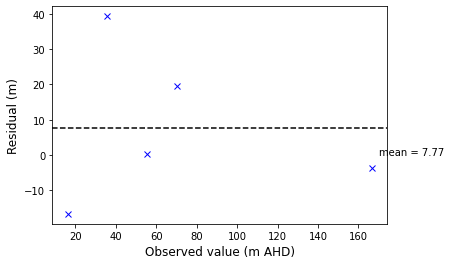

In [190]:
plt.plot(df_well_ixs_p1['rswl'], df_residuals_p['res_mean'], "bx")

mean_r = df_residuals_p['res_mean'].mean()

plt.axhline(y=mean_r, ls="--", color="k")
plt.xlabel("Observed value (m AHD)", fontsize=12)
plt.ylabel("Residual (m)", fontsize=12)
plt.text(170, 0, "mean = %2.2f" %mean_r)

plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper',
                         "residuals_p"), dpi=300)

# Residuals boxplot per map - predictions

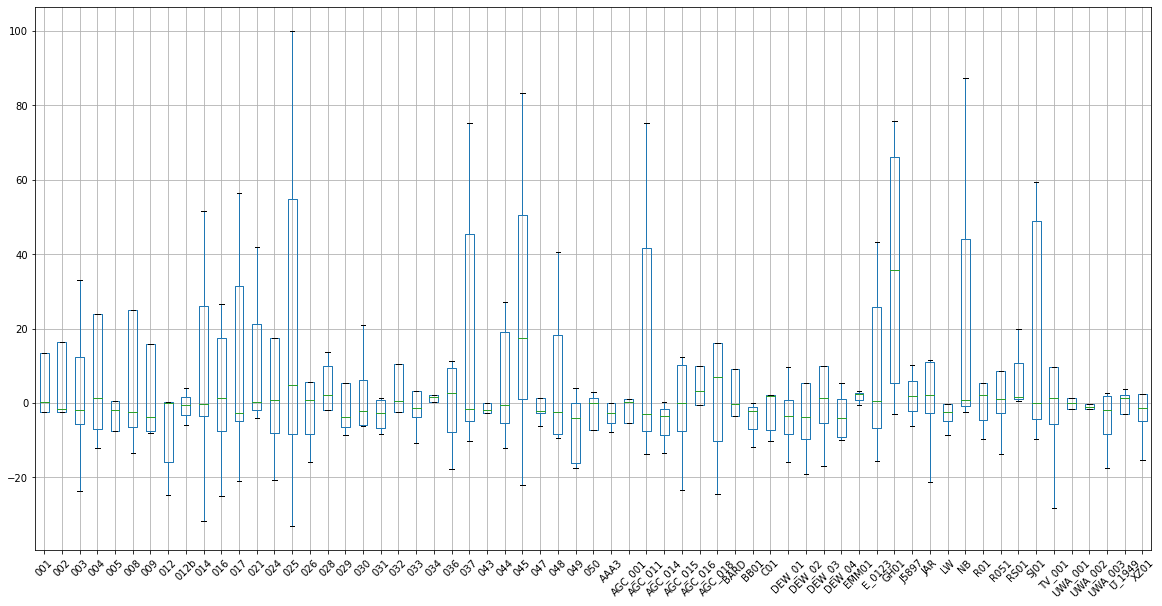

In [192]:
plt.figure(figsize=(20,10))
df_residuals_p[ar_name_list].boxplot(rot=45, showfliers=False)
plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper',
                         "resid_map_bplot_p"), dpi=300)

## Histogram - average error per map - predictions


In [193]:
df_residuals_p.index = df_well_ixs_p1.index
print(df_residuals_p.index)

Index(['27125', '39875', '42108', '46232', '180822'], dtype='object', name='DHNO')


In [194]:
# Add rswl data to prediction residuals
if 'rswl' in df_residuals_p.columns:
    pass
else:
    df_residuals_p = df_residuals_p.join(df_well_ixs_p1['rswl'], on=df_residuals_p.index)


In [195]:
df_residuals_p.head()

001        002        003        004        005         008  \
DHNO                                                                        
27125  -34.929733 -35.274833 -23.662199 -12.017036 -22.942319  -13.334894   
39875   65.481030  81.840870  32.923474  84.088612  58.316838  113.703999   
42108   -2.357184  -2.496313  -5.571265  -6.865790  -7.434988   -6.394583   
46232   13.318496  16.347694  12.481819  23.866447   0.517112   24.958412   
180822   0.217279  -1.718046  -1.771856   1.329607  -2.005545   -2.434584   

              009        012      012b        014  ...    UWA_003     U_1949  \
DHNO                                               ...                         
27125   -7.346605 -15.948539       NaN -31.793878  ... -17.526570        NaN   
39875         NaN -24.675819       NaN  51.713414  ...        NaN -15.628910   
42108   -8.062949   0.371210 -5.849417  -3.399420  ...  -5.232184   1.666772   
46232   62.879646   0.248092  3.917137  25.959343  ...   2.698799   3.800163   
180822   0.081324  -0.126776 -0.469206  -0.312162  ...   1.580282   1.131544   

             XZ01   n   res_mean      sq_mean  res_rt_sq_mn       25th  \
DHNO                                                                     
27125  -15.356676  54 -16.710555   279.242647     16.710555 -22.089987   
39875   50.800938  49  39.311591  1545.401202     39.311591  -1.653156   
42108   -4.939383  62  -3.568459    12.733900      3.568459  -6.355433   
46232    2.342376  63  19.420632   377.160959     19.420632   5.326557   
180822  -1.316683  63   0.384501     0.147841      0.384501  -1.436516   

             75th    rswl  
DHNO                       
27125   -9.708345   16.11  
39875   65.481030   35.77  
42108   -1.344862  166.65  
46232   25.905376   70.07  
180822   1.413732   55.58  

[5 rows x 70 columns]

In [196]:
rmse_per_map_p = []

for i in range(len(ar_name_list[1:])):
    a = df_residuals_p[ar_name_list[i]]
    rmse_per_map_p.append(np.sqrt((a**2).sum()/a.count()).mean())
    

In [197]:
print("Average prediction RMSE per well and per map: %2.2f"%np.mean(rmse_per_map_p))
print("Median prediction RMSE per well and per map: %2.2f"%np.median(rmse_per_map_p))

Average prediction RMSE per well and per map: 22.96
Median prediction RMSE per well and per map: 18.04


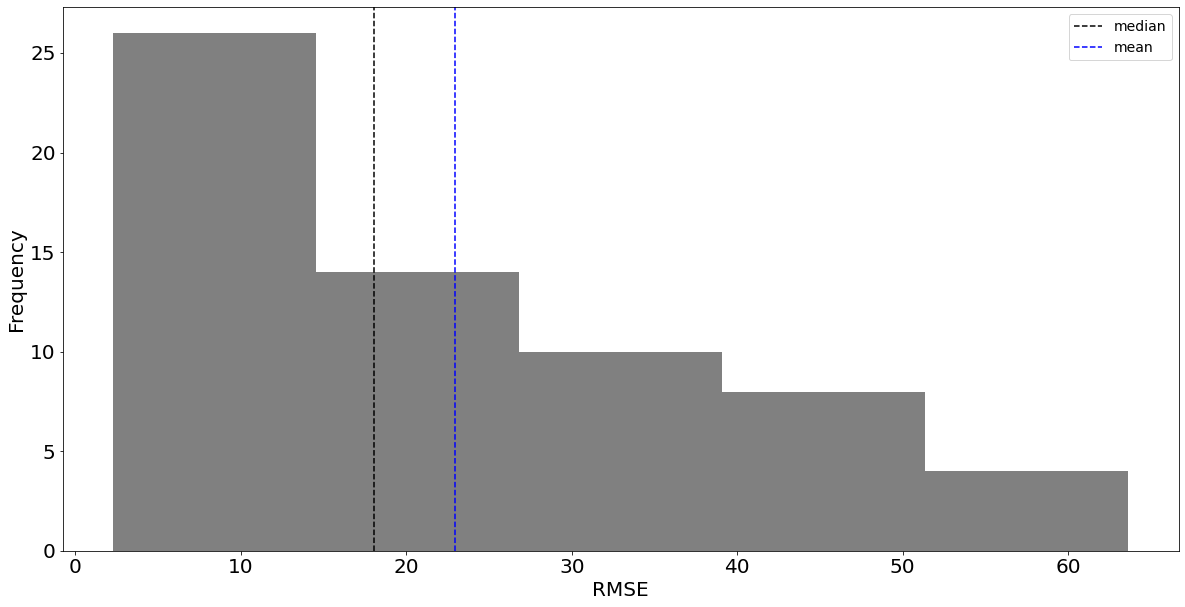

In [198]:
plt.figure(figsize=(20,10))
plt.hist(rmse_per_map_p, density=False, bins=5, color="0.5")
plt.axvline(np.median(rmse_per_map_p), ls='--', color="k", label="median")
plt.axvline(np.mean(rmse_per_map_p), ls='--', color="b", label="mean")
plt.gca().tick_params(axis='both', which='major', labelsize=20)

plt.legend(fontsize=14)

plt.xlabel("RMSE", fontsize=20)
plt.ylabel("Frequency", fontsize=20)

# Could change bins more regular
plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper',
                         "rmse_per_map_hist_p"), dpi=300)

## Sort residuals by rswl

In [199]:
df_residuals_p = df_residuals_p.sort_values(by="rswl")

df_residuals_p_r = df_residuals_p.copy()
df_residuals_p_r.index = df_residuals_p_r.rswl
df_residuals_p_r.head()

001        002        003        004        005         008  \
rswl                                                                        
16.11  -34.929733 -35.274833 -23.662199 -12.017036 -22.942319  -13.334894   
35.77   65.481030  81.840870  32.923474  84.088612  58.316838  113.703999   
55.58    0.217279  -1.718046  -1.771856   1.329607  -2.005545   -2.434584   
70.07   13.318496  16.347694  12.481819  23.866447   0.517112   24.958412   
166.65  -2.357184  -2.496313  -5.571265  -6.865790  -7.434988   -6.394583   

              009        012      012b        014  ...    UWA_003     U_1949  \
rswl                                               ...                         
16.11   -7.346605 -15.948539       NaN -31.793878  ... -17.526570        NaN   
35.77         NaN -24.675819       NaN  51.713414  ...        NaN -15.628910   
55.58    0.081324  -0.126776 -0.469206  -0.312162  ...   1.580282   1.131544   
70.07   62.879646   0.248092  3.917137  25.959343  ...   2.698799   3.800163   
166.65  -8.062949   0.371210 -5.849417  -3.399420  ...  -5.232184   1.666772   

             XZ01   n   res_mean      sq_mean  res_rt_sq_mn       25th  \
rswl                                                                     
16.11  -15.356676  54 -16.710555   279.242647     16.710555 -22.089987   
35.77   50.800938  49  39.311591  1545.401202     39.311591  -1.653156   
55.58   -1.316683  63   0.384501     0.147841      0.384501  -1.436516   
70.07    2.342376  63  19.420632   377.160959     19.420632   5.326557   
166.65  -4.939383  62  -3.568459    12.733900      3.568459  -6.355433   

             75th    rswl  
rswl                       
16.11   -9.708345   16.11  
35.77   65.481030   35.77  
55.58    1.413732   55.58  
70.07   25.905376   70.07  
166.65  -1.344862  166.65  

[5 rows x 70 columns]

# Residuals boxplots - per well

In [200]:
df_well_ixs_p1

DHNO    rswl     well_ix  well_ix_x  well_ix_y letter         001  \
DHNO                                                                          
27125    27125   16.11   (197, 17)        197         17      a  -18.819733   
39875    39875   35.77   (215, 66)        215         66      b  101.251030   
42108    42108  166.65   (36, 185)         36        185      i  164.292816   
46232    46232   70.07  (107, 154)        107        154      h   83.388496   
180822  180822   55.58  (109, 109)        109        109      f   55.797279   

               002         003         004  ...         R01        R051  \
DHNO                                        ...                           
27125   -19.164833   -7.552199    4.092964  ...    6.493284    2.373010   
39875   117.610870   68.693474  119.858612  ...   87.174255   87.110779   
42108   164.153687  161.078735  159.784210  ...  162.141174  164.024048   
46232    86.417694   82.551819   93.936447  ...   75.431305   78.599937   
180822   53.861954   53.808144   56.909607  ...   57.749840   56.577469   

              RS01        SJ01      TV_001     UWA_001     UWA_002  \
DHNO                                                                 
27125          NaN    6.522579  -12.192786   -4.780723    5.592253   
39875          NaN   95.288338  116.912025   65.049408   34.116844   
42108   168.187225  166.725616  160.953903  164.984131  165.618454   
46232    89.873474  118.982658   79.725548   70.062088   83.973251   
180822   55.987152   51.317474   56.790771   56.935711   55.227306   

           UWA_003      U_1949        XZ01  
DHNO                                        
27125    -1.416570         NaN    0.753324  
39875          NaN   20.141090   86.570938  
42108   161.417816  168.316772  161.710617  
46232    72.768799   73.870163   72.412376  
180822   57.160282   56.711544   54.263317  

[5 rows x 69 columns]

In [201]:
for i in df_well_ixs_p1.index:
    print(type(df_well_ixs_p1.loc[i, "letter"]))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [202]:
df_well_ixs_p1.loc[df_residuals_p.index[0], "letter"]

'a'

In [203]:
df_residuals_p

001        002        003        004        005         008  \
DHNO                                                                        
27125  -34.929733 -35.274833 -23.662199 -12.017036 -22.942319  -13.334894   
39875   65.481030  81.840870  32.923474  84.088612  58.316838  113.703999   
180822   0.217279  -1.718046  -1.771856   1.329607  -2.005545   -2.434584   
46232   13.318496  16.347694  12.481819  23.866447   0.517112   24.958412   
42108   -2.357184  -2.496313  -5.571265  -6.865790  -7.434988   -6.394583   

              009        012      012b        014  ...    UWA_003     U_1949  \
DHNO                                               ...                         
27125   -7.346605 -15.948539       NaN -31.793878  ... -17.526570        NaN   
39875         NaN -24.675819       NaN  51.713414  ...        NaN -15.628910   
180822   0.081324  -0.126776 -0.469206  -0.312162  ...   1.580282   1.131544   
46232   62.879646   0.248092  3.917137  25.959343  ...   2.698799   3.800163   
42108   -8.062949   0.371210 -5.849417  -3.399420  ...  -5.232184   1.666772   

             XZ01   n   res_mean      sq_mean  res_rt_sq_mn       25th  \
DHNO                                                                     
27125  -15.356676  54 -16.710555   279.242647     16.710555 -22.089987   
39875   50.800938  49  39.311591  1545.401202     39.311591  -1.653156   
180822  -1.316683  63   0.384501     0.147841      0.384501  -1.436516   
46232    2.342376  63  19.420632   377.160959     19.420632   5.326557   
42108   -4.939383  62  -3.568459    12.733900      3.568459  -6.355433   

             75th    rswl  
DHNO                       
27125   -9.708345   16.11  
39875   65.481030   35.77  
180822   1.413732   55.58  
46232   25.905376   70.07  
42108   -1.344862  166.65  

[5 rows x 70 columns]

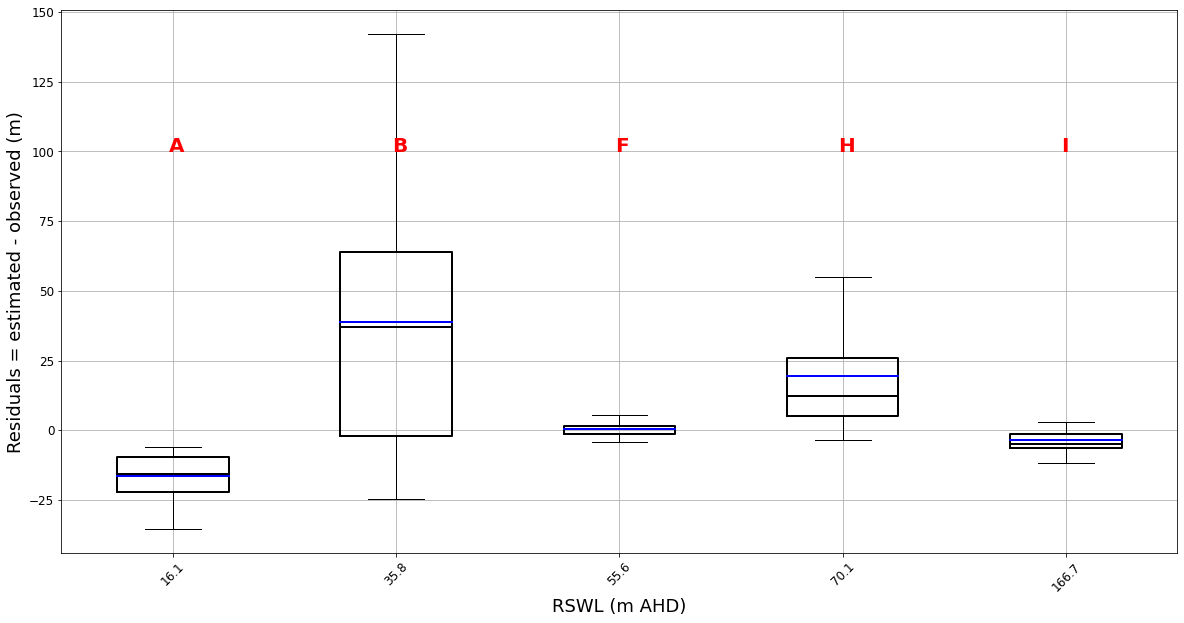

In [204]:
boxprops = dict(linestyle='-', linewidth=2, color="k")
medianprops = dict(linestyle='-', linewidth=2, color="k")
meanpointprops = dict(marker='.', markeredgecolor= "r", markerfacecolor = "r")
meanlineprops = dict(linestyle='-', linewidth=2, color='b')

colours = dict(boxes='k', whiskers='k', medians='k', caps='k')

plt.figure(figsize=(20,10))
df_residuals_p_r[ar_name_list[1:]].transpose().boxplot(rot=45, showfliers=False, showmeans=True, 
                                                     boxprops=boxprops, medianprops=medianprops,
                                                     meanline=True,meanprops=meanlineprops,  #meanpointprops,
                                                     color = colours,
                                                     fontsize=12, )
#plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%2.1f'))

# Changing the number of decimal points in the xlabels
ax = plt.gca()
labels = [item.get_text() for item in plt.gca().get_xticklabels()]
ax.set_xticklabels([str(round(float(label), 1)) for label in labels])


# Plot formatting
plt.xlabel("RSWL (m AHD)", fontsize=18)
plt.ylabel("Residuals = estimated - observed (m)", fontsize=18)

# Plot the letter above - can use df_residuals_p because it is also been sorted in order of rswl

for i in range(len(df_residuals_p.index)):
    xval = i+0.98
    yval = 100
    txt = df_well_ixs_p1.loc[df_residuals_p.index[i], "letter"].upper()
    plt.text(xval, yval, txt, fontsize=20, fontweight="bold", c="r")
    
# Save the figure
plt.savefig(os.path.join(r'C:\Users\mar886\WaterTableProject\Willunga\willunga_wt\figures\paper',
                         "resid_well_bplot_rswl_p"), dpi=300)


# DO A BOXPLOT WITH ALL OF THE DATA TOGETHER - CALIB AND PREDICT

In [ ]:
#df_residuals_r = df_residuals_r.rename(columns={"mean": "res_mean", "rt_sq_mean":"res_rt_sq_mn"})

In [205]:
print(df_well_ixs_p1.index)
print(df_residuals_p.index)

Index(['27125', '39875', '42108', '46232', '180822'], dtype='object', name='DHNO')
Index(['27125', '39875', '180822', '46232', '42108'], dtype='object', name='DHNO')


In [206]:
df_residuals_p.head() # Already sorted

df_well_ixs_p1 = df_well_ixs_p1.sort_values(by="rswl")

#df_well_ixs_p1.head()
#print(df_residuals_p.index)

print(df_well_ixs_p1.columns)
print(df_residuals_p.columns)

Index(['DHNO', 'rswl', 'well_ix', 'well_ix_x', 'well_ix_y', 'letter', '001',
       '002', '003', '004', '005', '008', '009', '012', '012b', '014', '016',
       '017', '021', '024', '025', '026', '028', '029', '030', '031', '032',
       '033', '034', '036', '037', '043', '044', '045', '047', '048', '049',
       '050', 'AAA3', 'AGC_001', 'AGC_011', 'AGC_014', 'AGC_015', 'AGC_016',
       'AGC_018', 'BARD', 'BB01', 'C01', 'DEW_01', 'DEW_02', 'DEW_03',
       'DEW_04', 'EMM01', 'E_0123', 'GH01', 'J5897', 'JAR', 'LW', 'NB', 'R01',
       'R051', 'RS01', 'SJ01', 'TV_001', 'UWA_001', 'UWA_002', 'UWA_003',
       'U_1949', 'XZ01'],
      dtype='object')
Index(['001', '002', '003', '004', '005', '008', '009', '012', '012b', '014',
       '016', '017', '021', '024', '025', '026', '028', '029', '030', '031',
       '032', '033', '034', '036', '037', '043', '044', '045', '047', '048',
       '049', '050', 'AAA3', 'AGC_001', 'AGC_011', 'AGC_014', 'AGC_015',
       'AGC_016', 'AGC_018', 'BARD', 

In [207]:
if "res_mean" in df_well_ixs_p1.columns:
    pass
else:
    df_well_ixs_p1 = df_well_ixs_p1.join(df_residuals_p['res_mean'], on=df_residuals_p.index)
    
if "res_rt_sq_mn" in df_well_ixs_p1.columns:
    pass
else:
    df_well_ixs_p1 = df_well_ixs_p1.join(df_residuals_p['res_rt_sq_mn'], on=df_residuals_p.index)

df_well_ixs_p1.head(2)

DHNO   rswl    well_ix  well_ix_x  well_ix_y letter         001  \
DHNO                                                                      
27125  27125  16.11  (197, 17)        197         17      a  -18.819733   
39875  39875  35.77  (215, 66)        215         66      b  101.251030   

              002        003         004  ...  RS01       SJ01      TV_001  \
DHNO                                      ...                                
27125  -19.164833  -7.552199    4.092964  ...   NaN   6.522579  -12.192786   
39875  117.610870  68.693474  119.858612  ...   NaN  95.288338  116.912025   

         UWA_001    UWA_002  UWA_003    U_1949       XZ01   res_mean  \
DHNO                                                                   
27125  -4.780723   5.592253 -1.41657       NaN   0.753324 -16.710555   
39875  65.049408  34.116844      NaN  20.14109  86.570938  39.311591   

       res_rt_sq_mn  
DHNO                 
27125     16.710555  
39875     39.311591  

[2 rows x 71 columns]

# Re-do spatial residuals figure - with prediction and calibration

## Add the mean residuals to the well ixs dataframe

In [208]:
cols_for_df = ar_name_list[1:] + ["rswl", "well_ix_x", "well_ix_y", "res_mean", "res_rt_sq_mn", "letter"]

In [209]:
df_well_ixs_both = df_well_ixs_c[cols_for_df].append(df_well_ixs_p1[cols_for_df])
df_well_ixs_both.tail()

002         003         004         005         008  \
DHNO                                                                 
27125   -19.164833   -7.552199    4.092964   -6.832319    2.775106   
39875   117.610870   68.693474  119.858612   94.086838  149.473999   
180822   53.861954   53.808144   56.909607   53.574455   53.145416   
46232    86.417694   82.551819   93.936447   70.587112   95.028412   
42108   164.153687  161.078735  159.784210  159.215012  160.255417   

               009         012        012b         014         016  ...  \
DHNO                                                                ...   
27125     8.763395    0.161461         NaN  -15.683878   -8.774357  ...   
39875          NaN   11.094181         NaN   87.483414   62.493080  ...   
180822   55.661324   55.453224   55.110794   55.267838   57.042633  ...   
46232   132.949646   70.318092   73.987137   96.029343   87.404228  ...   
42108   158.587051  167.021210  160.800583  163.250580  159.078644  ...   

           UWA_002     UWA_003      U_1949        XZ01    rswl  well_ix_x  \
DHNO                                                                        
27125     5.592253   -1.416570         NaN    0.753324   16.11        197   
39875    34.116844         NaN   20.141090   86.570938   35.77        215   
180822   55.227306   57.160282   56.711544   54.263317   55.58        109   
46232    83.973251   72.768799   73.870163   72.412376   70.07        107   
42108   165.618454  161.417816  168.316772  161.710617  166.65         36   

        well_ix_y   res_mean  res_rt_sq_mn  letter  
DHNO                                                
27125          17 -16.710555     16.710555       a  
39875          66  39.311591     39.311591       b  
180822        109   0.384501      0.384501       f  
46232         154  19.420632     19.420632       h  
42108         185  -3.568459      3.568459       i  

[5 rows x 68 columns]

## Define a function to truncate a colourmap - because i want to use greys but without the white part

In [210]:


import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
    
cmap = plt.get_cmap('gist_gray_r')
new_cmap = truncate_colormap(cmap, 0.3, 1)


# Define my colour scale

In [211]:
upr = df_well_ixs_both["res_mean"].max()
print(upr)
lwr = df_well_ixs_both["res_mean"].min()
print(lwr)
print(max([abs(upr),abs(lwr)]))

rangecol = max([abs(upr),abs(lwr)])*2 #upr - lwr

# Create a new upper and lower - because I want to use the absolute values so it's symmetrical

upr = max([abs(upr),abs(lwr)])
lwr = -max([abs(upr),abs(lwr)])

print(rangecol)
colour = cm.seismic_r(np.linspace(0, 1, int(rangecol+1)*100)) # coolwarm_r
print(int(rangecol+1)*100)

39.311591197422565
-35.2222428339178
39.311591197422565
78.62318239484513
7900


# Plot residuals

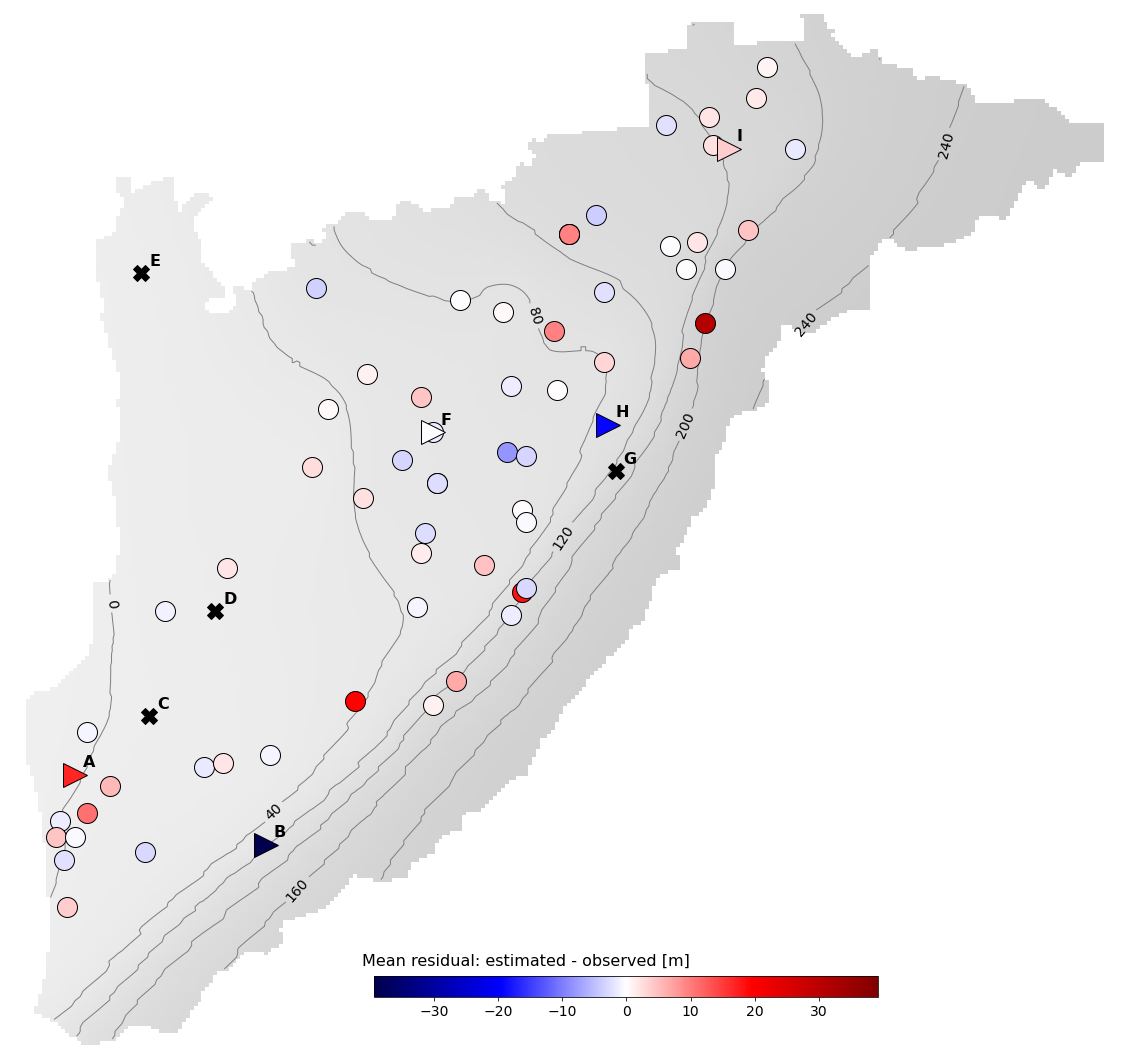

In [212]:
df = df_well_ixs_both

fig = plt.figure(figsize=(20,20))

axes=plt.subplot(111, frameon=False)

m = plt.imshow(mean_array, cmap=new_cmap, alpha=0.2)
cs = plt.contour(mean_array, colors="0.5", linewidths=1)
plt.clabel(cs, inline=1, fontsize=14, fmt='%1i', colors="k")
#cb = plt.colorbar(m, fraction=0.026, pad=0.06)

axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)

for t in cb.ax.get_yticklabels():
     t.set_fontsize(16)
        
cb.set_label("Standard devaition (m)", fontsize=25)

ii = 0
for i in range(len(df.index)):
    ix = df.index[i]
    y = df.loc[ix,"well_ix_x"]
    x = df.loc[ix,"well_ix_y"]
    letter = df.loc[ix,"letter"]
    value_r = df.loc[ix,"res_mean"]
    
    # Make the colour according to the value of the residual
    c = "k"
    c = colour[int((value_r - lwr)*100)]
    
    if type(letter)==float:
    # Plotting the markers
        plt.plot(x,y,'o',c=c, markersize=20, markeredgecolor="k", label='_nolegend_')
    #plt.text(x+2,y+3,"%2.1f"%(value_r), fontsize=16, fontweight='bold',c="k")
    else:
        plt.plot(x,y,'>',c=c, markersize=24, markeredgecolor="k", label='_nolegend_')
        plt.text(x+2,y-2, letter.upper(), fontsize=16, fontweight="bold")
        
        
# Add in other letters - no real data just measurement points
for i in range(len(df_well_ixs_p2.index)):
    ix = df_well_ixs_p2.index[i]
    y = df_well_ixs_p2.loc[ix,"well_ix_x"]
    x = df_well_ixs_p2.loc[ix,"well_ix_y"]
    letter = df_well_ixs_p2.loc[ix,"letter"]
    
    plt.plot(x,y,'X',c="k", markersize=16, markeredgecolor="k", label='_nolegend_')
    plt.text(x+2,y-2, letter.upper(), fontsize=16, fontweight="bold")

        
        
# Colourbar for the residuals
plt.subplots_adjust(top = 0.93, hspace=0.3, wspace=0.1) # , bottom=0.01, 
cmap = mpl.cm.ScalarMappable(
      norm = mcolors.Normalize(lwr, upr), 
      cmap = plt.get_cmap('seismic'))

cbaxes1 = fig.add_axes([0.38, 0.2, 0.35, 0.015]) 
cmap.set_array([])
cb = fig.colorbar(cmap,  cax=cbaxes1, orientation="horizontal")
cb.set_label("Mean residual: estimated - observed [m]", labelpad=-65, x=0.3, y=10, fontsize=16)
cb.ax.tick_params(labelsize=14)  
#axes.plot(x,y, "kx", alpha=1, markersize=10, label="Hydraulic head measurement")    
#plt.legend(frameon=False, fontsize=18, loc=4)

#plt.text(15,25, "(b)", fontsize=20)

nm = os.path.join(figure_directory, "map_residuals_c_p")
plt.savefig(nm, dpi=300)

# SURVEY DATA